<a href="https://colab.research.google.com/github/MAI3003-Data-Witches/Data-Witches_Project2/blob/main/MAI3003_DataWitches_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Witches**

| **Name**         | **Student ID** |
|------------------|----------------|
| Claessen, VVHJAE | i6339543       |
| Ovsiannikova, AM | i6365923       |
| Pubben, J        | i6276134       |
| Roca Cugat, M    | i6351071       |
| Záboj, J         | i6337952       |

# **Logbook**

**Changes**
Also see Git Commit History.

| **Version** | **Changes**      | **Date** |
|-------------|------------------|----------|
| v0.0        | Dataset loaded, EDA, cleaning   | 18-11-25 |
| v1.1        | *** | XX-11-25 |
| v0.2        | ***  | XX-11-25 |


## Methods

Let's ensure we all use the same names for all components.  

| **Variable**                   | **Name**                   |
|-------------------------------|----------------------------|
| Raw ECG dataframe             | df                         |
| Label dataframe               | df_labels                  |
| HRV features (train)          | hrv_train                  |
| HRV features (test)           | hrv_test                   |
|HRV extraction type           | FULL (nk.hrv — time + freq + nonlinear + RSA)|
| Clean HRV dataframe (train)   | hrv_train_clean            |
| Clean HRV dataframe (test)    | hrv_test_clean             |
| HRV + labels (train)          | hrv_train_with_labels      |
| Winsorized HRV column         | HRV_MedianNN_winsor       |
| Model feature matrix (train)  | X_train                    |
| Model feature matrix (test)   | X_test                     |
| Model target vector (train)   | y_train                    |
| Model target vector (test)    | y_test                     |


| **Function**              | **Description**                                | **Arguments**                                |
|---------------------------|------------------------------------------------|----------------------------------------------|
| corr_plot_hrv()           | Correlation plot for HRV features              | df, cols=None                                |
| distplots_hrv()           | Distribution plots (hist + KDE)                | df, cols=None                                |
| boxplots_hrv()            | Boxplots for selected HRV variables            | df, cols                                     |
| check_missing_hrv()       | Missingness summary                            | df                                           |
| identify_outliers()       | IQR-based outlier detection                    | df, column_name, threshold=1.5               |
| model_evaluation()        | Confusion matrix + classification report       | model                                        |
| model_desc()              | Accuracy, CV, ROC-AUC, model performance       | model                                        |


# Preface

## Packages imports

In [64]:
#!pip install -r requirements.txt

In [65]:
import random
import zipfile
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import welch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

## Options settings

In [66]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
random.seed(3003)

## Dataset download

In [67]:
#!./download_dataset.sh

In [68]:
df = pd.read_csv('data/Physionet2017TrainingData.csv', header=None, index_col=False) * 1000 # Load the dataset already in mV
#TODO: is it actually needed to convert to mV?

df.head()

0       1       2       3       4       5       6       7       8     \
0 -126000 -141000 -152000 -159000 -160000 -153000 -140000 -126000 -111000   
1   23000   25000   33000   61000   79000   85000   89000   93000   96000   
2 -116000 -146000 -174000 -190000 -199000 -207000 -211000 -211000 -207000   
3 -500000 -597000 -695000 -792000 -873000 -917000 -918000 -873000 -822000   
4  -74000  -96000 -118000 -141000 -153000 -162000 -169000 -174000 -177000   

     9       10      11      12      13      14      15      16      17    \
0  -93000  -72000  -46000  -17000       0   22000   55000   94000  123000   
1   98000   98000   99000  100000  100000  101000  101000  102000  102000   
2 -201000 -194000 -190000 -187000 -184000 -180000 -176000 -172000 -169000   
3 -767000 -751000 -740000 -730000 -722000 -715000 -709000 -703000 -698000   
4 -179000 -180000 -180000 -179000 -175000 -171000 -165000 -159000 -152000   

     18      19      20      21      22      23      24      25      26    \
0  145000  163000  169000  171000  171000  172000  172000  173000  174000   
1  102000  101000  102000  102000  103000  103000  103000  104000  106000   
2 -168000 -167000 -167000 -167000 -167000 -169000 -170000 -173000 -175000   
3 -695000 -693000 -691000 -690000 -689000 -687000 -685000 -683000 -682000   
4 -142000 -123000 -104000  -96000  -92000  -89000  -86000  -84000  -82000   

     27      28      29      30      31      32      33      34      35    \
0  173000  172000  172000  172000  171000  170000  169000  169000  170000   
1  108000  110000  111000  113000  115000  117000  118000  120000  121000   
2 -177000 -178000 -180000 -182000 -184000 -186000 -188000 -190000 -192000   
3 -681000 -680000 -680000 -681000 -684000 -688000 -695000 -701000 -706000   
4  -81000  -80000  -80000  -79000  -77000  -75000  -75000  -74000  -73000   

     36      37      38      39      40      41      42      43      44    \
0  169000  169000  171000  173000  176000  178000  181000  185000  191000   
1  124000  127000  131000  135000  139000  144000  147000  151000  155000   
2 -194000 -196000 -197000 -199000 -199000 -199000 -198000 -197000 -194000   
3 -713000 -720000 -727000 -733000 -737000 -740000 -743000 -747000 -753000   
4  -73000  -72000  -71000  -70000  -70000  -69000  -69000  -68000  -67000   

     45      46      47      48      49      50      51      52      53    \
0  203000  214000  227000  249000  277000  296000  312000  335000  367000   
1  160000  166000  173000  186000  199000  213000  229000  248000  267000   
2 -191000 -187000 -183000 -179000 -175000 -171000 -167000 -163000 -158000   
3 -762000 -768000 -772000 -774000 -776000 -778000 -780000 -777000 -769000   
4  -65000  -64000  -62000  -61000  -60000  -59000  -59000  -60000  -61000   

     54      55      56      57      58      59      60      61      62    \
0  402000  426000  444000  470000  494000  514000  528000  536000  543000   
1  276000  280000  284000  286000  288000  290000  292000  295000  297000   
2 -153000 -148000 -144000 -139000 -135000 -131000 -127000 -124000 -122000   
3 -758000 -746000 -731000 -722000 -715000 -710000 -706000 -703000 -701000   
4  -63000  -65000  -68000  -71000  -74000  -76000  -79000  -80000  -82000   

     63      64      65      66      67      68      69      70      71    \
0  549000  554000  556000  557000  555000  550000  544000  537000  531000   
1  300000  302000  305000  307000  311000  314000  318000  323000  334000   
2 -120000 -119000 -118000 -117000 -115000 -113000 -112000 -111000 -110000   
3 -699000 -697000 -693000 -689000 -684000 -680000 -677000 -674000 -670000   
4  -84000  -86000  -89000  -90000  -89000  -86000  -80000  -73000  -64000   

     72      73      74      75      76      77      78      79      80    \
0  528000  525000  521000  516000  512000  509000  505000  502000  498000   
1  345000  356000  361000  364000  367000  370000  373000  375000  376000   
2 -110000 -109000 -108000 -107000 -106000 -105000 -104000 -102000 -101

# Data preprocessing
## Extract ECG signals and class labels

In [69]:
df_labels = pd.read_csv('data/Physionet2017TrainingLabels.csv', header=None, names=['label'])
df_labels['label'] = df_labels['label'].replace({0: 'Normal Sinus Rhythm', 1: 'Atrial Fibrillation'})
# 0: Normal Sinus Rhythm
# 1: Atrial Fibrillation

## Dataset splitting

In [70]:
#df_labeled = pd.merge(hrv_df_clean, df_labels, left_on='ecg_index', right_index=True)

train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df_labels["label"],
    random_state=3003
)

print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


# Functions Definitions

## Correlation plot

In [71]:
# Correlation plot
def corr_plot_hrv(df, cols=None):
    """
    Correlation heatmap for HRV features.
    """
    data = df[cols] if cols else df.select_dtypes("number")
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), cmap="coolwarm", center=0)
    plt.title("Correlation Map (HRV Features)")
    plt.show()

## Distribution plots

In [72]:
# Distribution plots
def distplots_hrv(df, cols=None):
    """
    Distribution plots (hist + KDE) for HRV features.
    """
    data = df[cols] if cols else df.select_dtypes("number")
    for col in data.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(data[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

def distplots(df):
    numeric_df = df.select_dtypes(include=['number'])
    num_features = len(numeric_df.columns)
    cols = int(np.ceil(np.sqrt(num_features)))
    rows = int(np.ceil(num_features / cols))

    # A figure with subplots looks much nicer
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(numeric_df.columns):
        # Technically not needed but might as well
        numeric_df_nona = numeric_df[column].dropna()

        axes[i].hist(numeric_df_nona, bins=30, alpha=0.7, edgecolor='black')

        if len(numeric_df_nona) > 1:
            density = stats.gaussian_kde(numeric_df_nona)
            xs = np.linspace(numeric_df_nona.min(), numeric_df_nona.max(), 200)
            axes[i].plot(xs, density(xs) * len(numeric_df_nona) * (numeric_df_nona.max() - numeric_df_nona.min()) / 30,
                         'r-', linewidth=2)

        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Number of Patients')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].grid(axis='y', alpha=0.3)

    # Remove any empty subplots if they exist
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Boxplots

In [73]:
# Boxplots
def boxplots_hrv(df, cols):
    """
    Boxplots for detecting unusual HRV values.
    """
    for col in cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

## Missingness overview

In [74]:
# Missingness
def check_missing_hrv(df):
    """
    Summarize missingness across HRV features.
    """
    missing = df.isna().sum()
    out = pd.DataFrame({
        "feature": df.columns,
        "missing_n": missing,
        "missing_%": (missing / len(df))*100
    })
    display(out.sort_values("missing_%", ascending=False))
    return out

# Exploratory Data Analysis
## Dataset characteristics

In [75]:
num_ecgs = len(df) # Number of ECGs

num_samples = df.shape[1] # Number of samples per ECG

sampling_frequency = 300#Hz
duration = num_samples / sampling_frequency # Duration of each ECG

class_distribution = df_labels['label'].value_counts() # Distribution over classes #TODO: quick pie chart?

print(f"Number of ECGs: {num_ecgs}")
print(f"Number of samples per ECG: {num_samples}")
print(f"Duration of each ECG: {duration} seconds")
print(f"\nClass Distribution:\n{class_distribution}")

Number of ECGs: 4524
Number of samples per ECG: 9000
Duration of each ECG: 30.0 seconds

Class Distribution:
label
N    3950
A     574
Name: count, dtype: int64


In [76]:
# Indices per class (based on df_labels)
sinus_indices = df_labels[df_labels["label"] == "Normal Sinus Rhythm"].index.tolist()
af_indices    = df_labels[df_labels["label"] == "Atrial Fibrillation"].index.tolist()

example_sinus_idx = random.choice(sinus_indices)
example_af_idx    = random.choice(af_indices)

ecg_sinus_raw = df.iloc[example_sinus_idx].astype(float).values
ecg_af_raw    = df.iloc[example_af_idx].astype(float).values

time = np.arange(0, len(ecg_sinus_raw)) / sampling_frequency

plt.figure(figsize=(14, 4))
plt.plot(time, ecg_sinus_raw, label=f"NSR (index {example_sinus_idx})")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Example raw ECG – Normal Sinus Rhythm")
plt.legend()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(time, ecg_af_raw, label=f"AF (index {example_af_idx})", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Example raw ECG – Atrial Fibrillation")
plt.legend()
plt.show()

IndexError: Cannot choose from an empty sequence

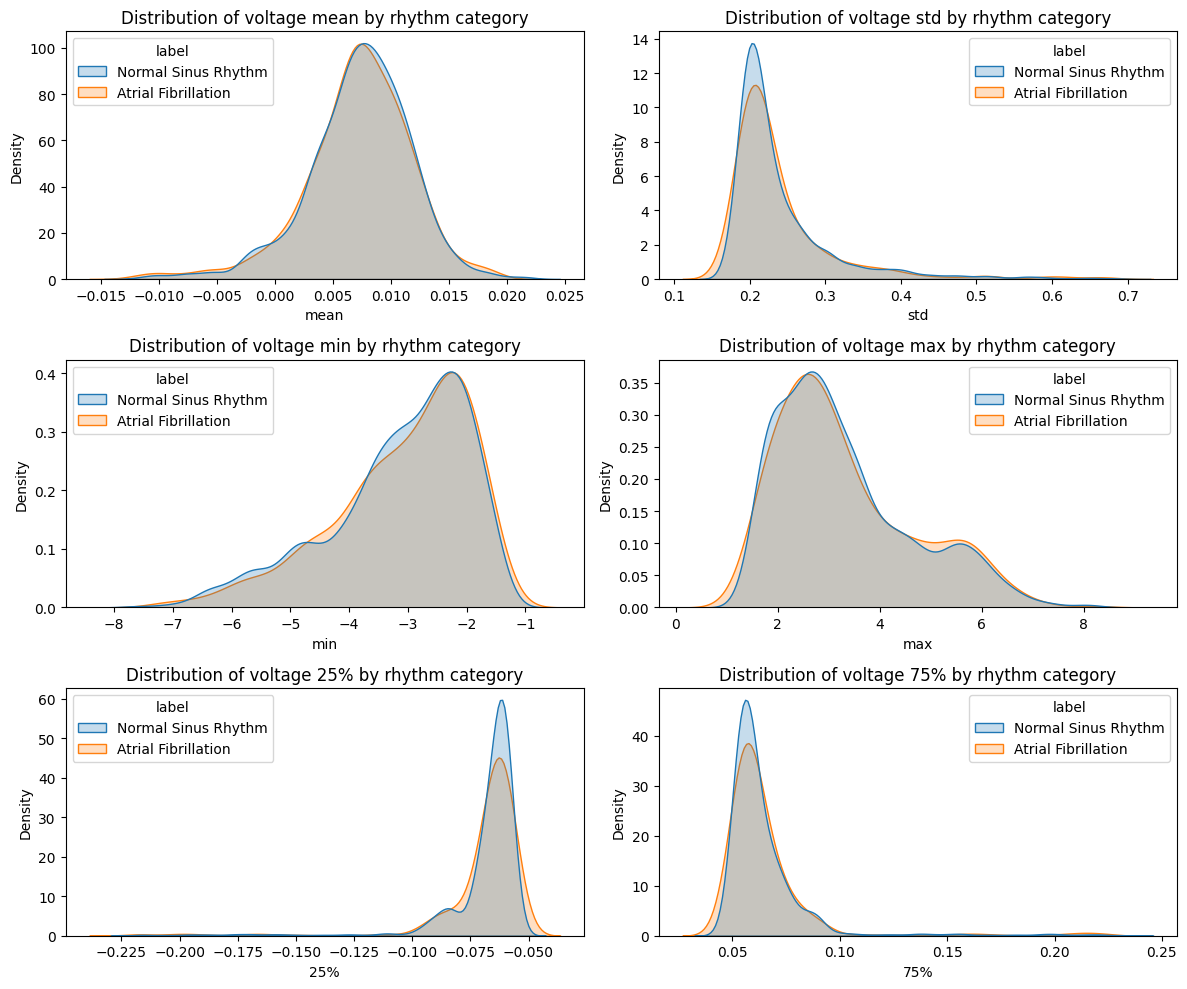

In [60]:
# Summary statistics for each ECG
summary_stats = df.describe().T
summary_stats = pd.concat([summary_stats, df_labels], axis=1)

# Plotting the distributions of summary statistics
stats_to_plot = ['mean', 'std', 'min', 'max', '25%', '75%']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, stat in enumerate(stats_to_plot):
  sns.kdeplot(ax=axes[i], data=summary_stats, x=stat, hue='label', fill=True, common_norm=False)
  axes[i].set_title(f'Distribution of voltage {stat} by rhythm category')
plt.tight_layout()
plt.show()

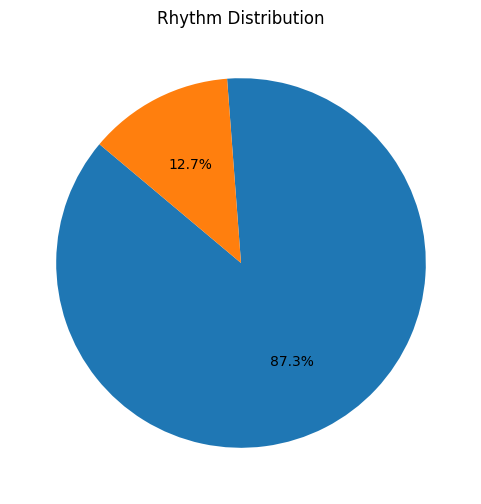

In [61]:
counts = df_labels.label.value_counts().tolist()

plt.figure(figsize=(6, 6))
plt.pie(counts, autopct='%1.1f%%', startangle=140)
plt.title('Rhythm Distribution')
plt.show()

## ECG exploration
Let's have a look at the ECG signals. The AliveCor ECGs are single lead ECGs, similar to **Lead I** in a standard 12-lead ECG. First, we determine which ECGs are in Normal Sinus Rhythm, and which ECGs are in Atrial Fibrillation

In [62]:
# Randomly select ECGs from each class
number_of_selectedECGs = 1  # change to plot more ECGs for each rhythm category
selected_sinus_indices = random.sample(sinus_indices, number_of_selectedECGs)
selected_af_indices = random.sample(af_indices, number_of_selectedECGs)

# Create subplots
fig = make_subplots(rows=number_of_selectedECGs, cols=2, subplot_titles=("Normal Sinus Rhythm", "Atrial Fibrillation"))

# Plot NSR ECGs on the left subplot
for i, index in enumerate(selected_sinus_indices):
    time = np.arange(0, len(df.iloc[index])) / sampling_frequency  # Assuming sampling_frequency is defined
    fig.add_trace(go.Scatter(x=time, y=df.iloc[index], mode='lines', name=f'ECG {index + 1}'), row=i+1, col=1)

# Plot AF ECGs on the right subplot
for i, index in enumerate(selected_af_indices):
    time = np.arange(0, len(df.iloc[index])) / sampling_frequency  # Assuming sampling_frequency is defined
    fig.add_trace(go.Scatter(x=time, y=df.iloc[index], mode='lines', name=f'ECG {index + 1}'), row=i+1, col=2)

# Update layout
fig.update_layout(title_text="Selected ECGs: NSR vs. AF",
                  xaxis_title='Time (s)',
                  yaxis_title='Voltage (mV)',
                  showlegend=False,)

fig.show()

## ECG frequency analysis
An important feature of any signal is the frequency content: it tells us which frequency a predominantly present in the signal. In this case, differences in cardiac rhythm may be associated with differences in frequency content. The following code computes the frequency content of an ECG signal using the *Fourier transform* (`fft` in Python).

**Question:** how could we differentiate between NSR and AF based on the frequency content?

In [63]:
# Show the frequency content of each of the selected ECGs
from scipy.fft import fft, fftfreq

# Create subplots
num_ecgs = len(selected_sinus_indices) + len(selected_af_indices)

subplot_titles = []
for index in selected_sinus_indices + selected_af_indices:
    subplot_titles.extend([f"ECG {index+1}", f"FFT {index+1}"])

fig = make_subplots(rows=num_ecgs, cols=2, subplot_titles=subplot_titles)

# Plot selected ECGs and their FFTs
row_num = 1
for index in selected_sinus_indices + selected_af_indices:
    ecg_signal = df.iloc[index].astype(float)
    time = np.arange(0, len(ecg_signal)) / sampling_frequency

    # Calculate FFT
    ecg_data = np.asarray(ecg_signal)
    N = len(ecg_data)
    yf = fft(ecg_data)
    xf = fftfreq(N, 1 / sampling_frequency)
    xf = xf[:N // 2]  # Only consider positive frequencies
    yf = 2.0 / N * np.abs(yf[:N // 2])

    # Plot ECG on the left subplot
    fig.add_trace(go.Scatter(x=time, y=ecg_signal, mode='lines', name=f'ECG {index + 1}'), row=row_num, col=1)

    # Plot FFT on the right subplot
    fig.add_trace(go.Scatter(x=xf, y=yf, mode='lines', name=f'FFT {index + 1}'), row=row_num, col=2)

    row_num += 1

# Update layout
fig.update_layout(title_text="Selected ECGs and FFTs",
                  xaxis_title='Time (s)',
                  xaxis2_title='Frequency (Hz)',
                  yaxis_title='Amplitude',
                  yaxis2_title='Magnitude',
                  showlegend=False,
                  height=num_ecgs * 300)  # Adjust height based on the number of ECGs

fig.show()

The *Welch periodogram* is an approach to estimate the frequency content of a signal that computes the *average* spectrogram of overlapping signal segments.

In [64]:
# Compute the Welch periodogram instead of the fft
# Show the frequency content of each of the selected ECGs using Welch's method

# Create subplots
num_ecgs = len(selected_sinus_indices) + len(selected_af_indices)

subplot_titles = []
for index in selected_sinus_indices + selected_af_indices:
    subplot_titles.extend([f"ECG {index+1}", f"Welch Periodogram {index+1}"])

fig = make_subplots(rows=num_ecgs, cols=2, subplot_titles=subplot_titles)

# Plot selected ECGs and their Welch periodograms
numberOfSamplesPerFFT=1024
row_num = 1
for index in selected_sinus_indices + selected_af_indices:
    ecg_signal = df.iloc[index].astype(float)
    time = np.arange(0, len(ecg_signal)) / sampling_frequency

    # Calculate Welch periodogram
    ecg_data = np.asarray(ecg_signal) # Convert pandas Series to NumPy array
    frequencies, power_spectrum = welch(ecg_data, fs=sampling_frequency, nperseg=numberOfSamplesPerFFT)

    # Plot ECG on the left subplot
    fig.add_trace(go.Scatter(x=time, y=ecg_signal, mode='lines', name=f'ECG {index + 1}'), row=row_num, col=1)

    # Plot Welch periodogram on the right subplot
    fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name=f'Welch {index + 1}'), row=row_num, col=2)

    row_num += 1

# Update layout
fig.update_layout(title_text="Selected ECGs and Welch Periodograms",
                  xaxis_title='Time (s)',
                  xaxis2_title='Frequency (Hz)',
                  yaxis_title='Amplitude',
                  yaxis2_title='Power Spectral Density',
                  showlegend=False,
                  height=num_ecgs * 300)  # Adjust height based on the number of ECGs

fig.show()

# We do not need synthetic data

In [65]:
# We use the neurokit package to simulate ECG signals
#Install neurokit2 if needed
!pip install neurokit2
import neurokit2 as nk

### Powerline interference

In [66]:
# simulate an ECG
ecg_sim = nk.ecg_simulate(duration=5, sampling_rate = sampling_frequency, method="ecgsyn")
time = np.arange(0, len(ecg_sim)) / sampling_frequency

# Add a 50Hz signal
frequency = 50  # Hz
amplitude = 0.1  # Adjust the amplitude as needed
signal_50hz = amplitude * np.sin(2 * np.pi * frequency * time)

# Add the 50Hz signal to ecg_sim
ecg_sim_with_50hz = ecg_sim + signal_50hz

# Plot both signals
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim_with_50hz, mode='lines', name='ECG with 50Hz Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.update_layout(title_text="ECG Signals: Original vs. with 50Hz Noise",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

In [67]:
# Compute and show the Welch periodogram of the 50Hz ecg signal
frequencies, power_spectrum = welch(ecg_sim_with_50hz, fs=sampling_frequency, nperseg=1024)

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name='Welch Periodogram'))
fig.update_layout(title_text="Welch Periodogram of 50Hz ECG Signal",
                  xaxis_title="Frequency (Hz)",
                  yaxis_title="Power Spectral Density")
fig.show()

Now we create a so-called *notch filter*: this is a filter that supresses a certain frequency in a signal, in this case 50Hz

In [68]:
# Standard signal processing algorithm can be found in the package scipy.signal
import scipy.signal as signal

# filter design
notch_freq = 50 # frequency that we want to filter out
quality_factor = 30
nyquist_freq = 0.5 * sampling_frequency
normalized_notch_freq = notch_freq / nyquist_freq
b, a = signal.iirnotch(normalized_notch_freq, quality_factor)

# apply the filter to the signal with noise
filtered_ecg = signal.filtfilt(b, a, ecg_sim_with_50hz)

# Plot the original signal with noise and filtered signal
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim_with_50hz, mode='lines', name='ECG with 50Hz Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=filtered_ecg, mode='lines', name='Filtered ECG'))

fig.update_layout(title_text="ECG Signals: with 50Hz Noise vs. Filtered",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

###Baseline wander

In [69]:
# Simulate an ECG
sampling_frequency = 300  # Hz
ecg_sim = nk.ecg_simulate(duration=10, sampling_rate=sampling_frequency, method="ecgsyn")
time = np.arange(0, len(ecg_sim)) / sampling_frequency

# Add baseline wander
wander = 0.5 * np.sin(2 * np.pi * 0.3 * time)  # 0.3 Hz baseline wander
ecg_wander = ecg_sim + wander

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_wander, mode='lines', name='ECG with Wander'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.update_layout(title_text="ECG Signals: Baseline Wandering",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")

In [70]:
# Compute and show the Welch periodogram of the baseline wander ecg signal
frequencies, power_spectrum = welch(ecg_wander, fs=sampling_frequency, nperseg=1024)

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name='Welch Periodogram'))
fig.update_layout(title_text="Welch Periodogram of baseline wander ECG Signal",
                  xaxis_title="Frequency (Hz)",
                  yaxis_title="Power Spectral Density")
fig.show()

In [71]:
# Apply a median filter
window_size = 101  # Adjust window size as needed
ecg_median_filtered = ecg_wander - signal.medfilt(ecg_wander, kernel_size=window_size)

# Apply a 0.5Hz high-pass filter
cutoff_freq = 0.5  # Hz
nyquist_freq = 0.5 * sampling_frequency
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, btype='high', analog=False)
ecg_highpass_filtered = signal.filtfilt(b, a, ecg_wander)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_wander, mode='lines', name='ECG with Wander'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=ecg_median_filtered, mode='lines', name='ECG Median Filtered'))
fig.add_trace(go.Scatter(x=time, y=ecg_highpass_filtered, mode='lines', name='ECG High-pass Filtered'))

fig.update_layout(title_text="ECG Signals: Baseline Wander Removal Comparison",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

###Muscle noise

In [72]:
# Generate EMG noise at random intervals
emg_noise = np.zeros_like(ecg_sim)

std_dev_emg_noise = 0.05
duration_emg_noise = int(0.05 * sampling_frequency)

for _ in range(10 * 20):  # Assuming an average of 20 contractions per second
    start = np.random.randint(0, len(ecg_sim) - duration_emg_noise)
    emg_noise[start:start + duration_emg_noise] += np.random.normal(0, std_dev_emg_noise, duration_emg_noise)

# Combine ECG signal with EMG noise
ecg_muscle = ecg_sim + emg_noise

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=ecg_muscle, mode='lines', name='ECG with Muscle Noise'))
fig.update_layout(title_text="ECG Signals: Muscle Noise",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")

In [73]:
# Apply a 100Hz low-pass filter
cutoff_freq = 100  # Hz
nyquist_freq = 0.5 * sampling_frequency
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
ecg_lowpass_filtered = signal.filtfilt(b, a, ecg_sim)

# Plot the original signal with noise and filtered signal
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_muscle, mode='lines', name='ECG with Muscle Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_lowpass_filtered, mode='lines', name='ECG Low-pass Filtered'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG',
                         line=dict(color='gray', width=1.5)))
fig.update_layout(title_text="ECG Signals: with Muscle Noise vs. Filtered",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

##ECG feature engineering

Tradionally, ECG analysis is done visually, with a cardiologist/electrophysiologist that assesses the ECG signal(s) and makes a diagnosis based on standardized criteria (for instance the [Minnesota Code](https://link.springer.com/book/10.1007/978-1-84882-778-3)). Conventional ECG analysis tool translate these criteria into a set of automated algorithms that extract features that can then be used to classify the rhythm on an ECG. Standard criteria to diagnose AF from an ECG are:
- Required
  - Absence of a visible P-wave
  - Irregularly irregular heart rhythm
- Optional
  - Presence of f-waves / absence of isoelectric baseline
  - Fast ventricular rate

In this workshop we will focuse on crafting features related to heart rate variability, as the visibility of the P-wave is often limited in lead I, due to its low amplitude.

###Feature extraction using NeuroKit

NeuroKit can be used to process ECG and compute features related to *heart rate variability* (HRV). See https://doi.org/10.3390/s21123998 for an overview of HRV features.

The package computes features in 3 domains:
- *time domain*: features based on variability in the heart rate intervals (R-R intervals)
- *frequency domain*: frequency content of the R-R interval series, reflecting parasympathetic and sympathetic activity
- *nonlinear dynamics*: features that try to capture the underlying dynamics of the R-R series. The Poincare plot is a well-known example of a nonlinear analysis.

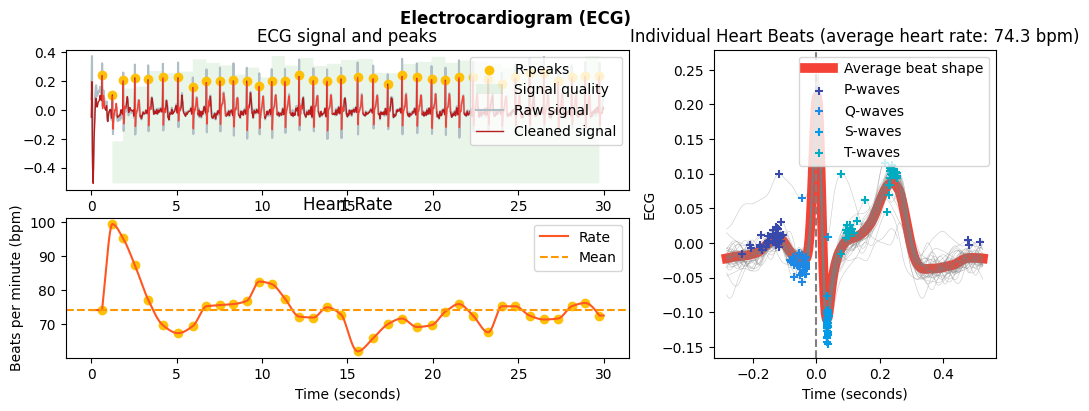

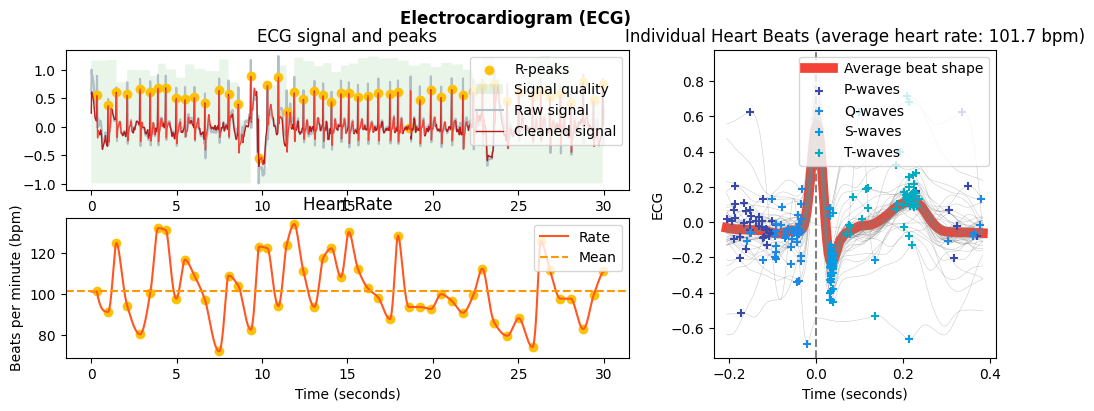

In [74]:
# Select an ECG in Normal Sinus Rhythm and one in AF and process them
selected_sinus_indices = random.sample(sinus_indices, 1)
selected_af_indices = random.sample(af_indices, 1)

ecg_NSR = df.iloc[selected_sinus_indices[0]].astype(float)
signals_NSR, info_NSR = nk.ecg_process(ecg_NSR, sampling_rate=sampling_frequency)

# Visualise the processing
plt.rcParams['figure.figsize'] = [12, 4]
nk.ecg_plot(signals_NSR, info_NSR)

ecg_AF = df.iloc[selected_af_indices[0]].astype(float)
signals_AF, info_AF = nk.ecg_process(ecg_AF, sampling_rate=sampling_frequency)

# Visualise the processing
nk.ecg_plot(signals_AF, info_AF)

####**R-peaks**

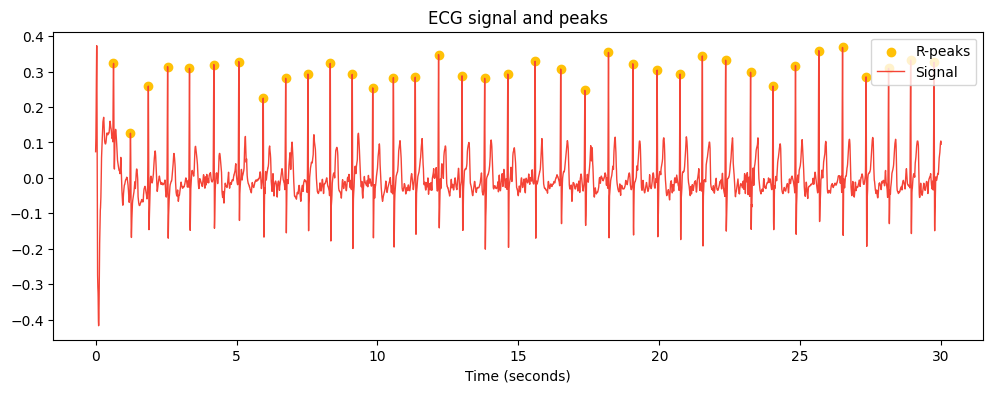

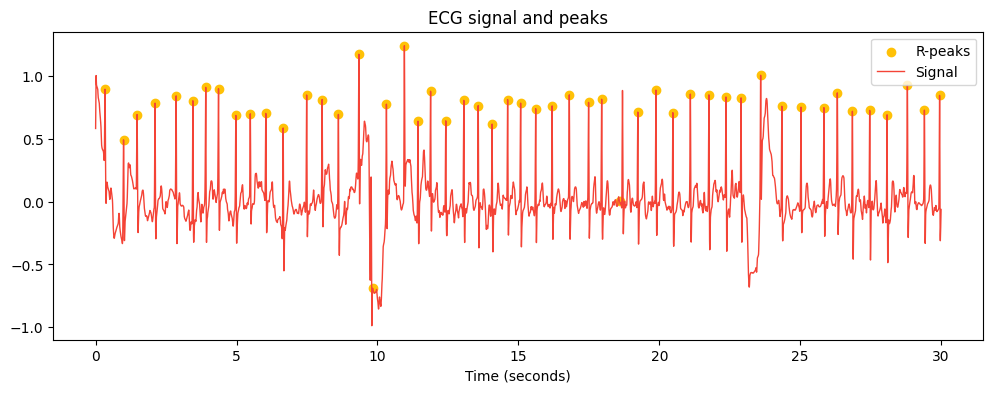

In [75]:
# Find R-peaks
peaks_NSR, info_NSR = nk.ecg_peaks(ecg_NSR, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)
peaks_AF, info_AF = nk.ecg_peaks(ecg_AF, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)

#### **Time-domain features**

HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  808.703704  70.252505         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN  49.009231  49.288684  0.086871  0.060602   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN  HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0         815.0     42.007   0.051542  55.833333     1.433455        780.0   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN  HRV_MaxNN  HRV_HTI  HRV_TINN  
0   863.333333       25.0  58.333333  603.333333      970.0      6.0  195.3125

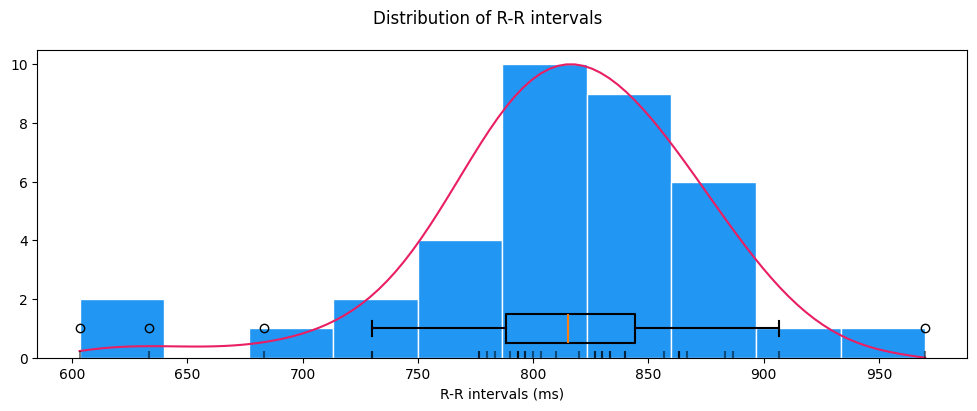

In [76]:
# Time domain features NSR
hrv_time_NSR = nk.hrv_time(peaks_NSR, sampling_rate=sampling_frequency, show=True)
hrv_time_NSR

HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0       592.2  94.81958         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN  124.880896  126.152098  0.160114  0.210876   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0    601.666667     93.898   0.156063  126.666667      0.75928   492.666667   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN   HRV_MaxNN  HRV_HTI  \
0   657.333333       70.0       84.0  446.666667  833.333333     10.0   

   HRV_TINN  
0  164.0625

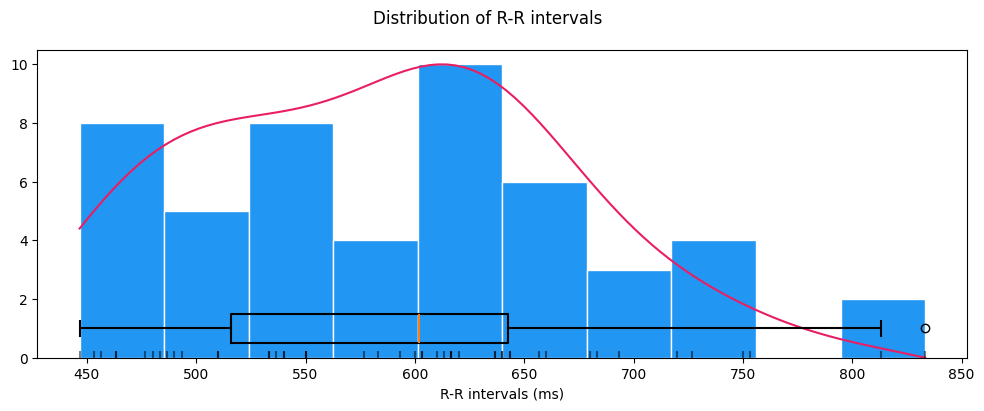

In [77]:
# Time domain features AF
hrv_time_AF = nk.hrv_time(peaks_AF, sampling_rate=sampling_frequency, show=True)
hrv_time_AF

###**FULL HRV feature extraction for all ECGs (TRAIN)**

In [78]:
#FULL HRV feature extraction for all ECGs (TRAIN)

from tqdm import tqdm

hrv_features_train = []

for i in tqdm(train_idx, desc="HRV (ALL FEATURES): TRAIN SET"):
    # Grab raw ECG
    ecg = df.iloc[i].astype(float).values

    try:
        # 1. Clean ECG
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

        # 2. Detect R-peaks
        peaks, _ = nk.ecg_peaks(
            ecg_clean,
            sampling_rate=sampling_frequency,
            correct_artifacts=True
        )

        # 3. Compute FULL HRV feature set
        hrv_full = nk.hrv(
            peaks,
            sampling_rate=sampling_frequency,
            show=False
        )

        # Ensure row is a proper 1-row DataFrame and add ecg_index
        hrv_full = hrv_full.copy()
        hrv_full["ecg_index"] = i

        hrv_features_train.append(hrv_full)

    except Exception as e:
        print(f"Error processing TRAIN ECG {i}: {e}")

        if hrv_features_train:
            empty = pd.DataFrame(
                [np.nan] * hrv_features_train[0].shape[1],
                index=hrv_features_train[0].columns
            ).T
            empty["ecg_index"] = i
            hrv_features_train.append(empty)

# Combine to single DataFrame
hrv_train = pd.concat(hrv_features_train, ignore_index=True)

print("hrv_train shape:", hrv_train.shape)
hrv_train.head()

HRV (ALL FEATURES): TRAIN SET: 100%|██████████| 3619/3619 [03:49<00:00, 15.78it/s]


hrv_train shape: (3619, 84)


HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  523.696970   94.576537         NaN         NaN         NaN         NaN   
1  803.148148   53.004609         NaN         NaN         NaN         NaN   
2  772.342342   22.809800         NaN         NaN         NaN         NaN   
3  711.916667  134.978921         NaN         NaN         NaN         NaN   
4  875.252525   88.439521         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN  132.207438  133.441154  0.180594  0.252450   
1         NaN         NaN   18.567765   18.306958  0.065996  0.023119   
2         NaN         NaN   18.625616   18.888889  0.029533  0.024116   
3         NaN         NaN  149.905953  151.840313  0.189599  0.210567   
4         NaN         NaN  132.455443  134.462290  0.101045  0.151334   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0    496.666667     79.072   0.159205   98.333333     0.715365   446.666667   
1    816.666667     51.891   0.063540   85.000000     2.854657   743.333333   
2    773.333333     19.768   0.025562   26.666667     1.224647   760.666667   
3    703.333333    158.144   0.224849  215.000000     0.900424   578.666667   
4    856.666667     59.304   0.069226   73.333333     0.667693   828.000000   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN    HRV_MaxNN    HRV_HTI  \
0   586.000000  56.363636  80.000000  410.000000   823.333333   9.166667   
1   850.000000   0.000000  22.222222  696.666667   886.666667   7.200000   
2   792.666667   0.000000  27.027027  710.000000   810.000000   3.700000   
3   830.000000  70.000000  82.500000  473.333333  1043.333333  13.333333   
4   934.666667  72.727273  87.878788  660.000000  1080.000000  11.000000   

   HRV_TINN  HRV_ULF  HRV_VLF  HRV_LF    HRV_HF   HRV_VHF    HRV_TP  HRV_LFHF  \
0   54.6875      NaN      NaN     NaN  0.105635  0.058618  0.164253       NaN   
1   93.7500      NaN      NaN     NaN  0.012677  0.000206  0.012883       NaN   
2   85.9375      NaN      NaN     NaN  0.062933  0.000665  0.063599       NaN   
3  234.3750      NaN      NaN     NaN  0.101500  0.009380  0.110879       NaN   
4  234.3750      NaN      NaN     NaN  0.170393  0.021643  0.192037       NaN   

   HRV_LFn   HRV_HFn  HRV_LnHF     HRV_SD1     HRV_SD2  HRV_SD1SD2  \
0      NaN  0.643123 -2.247767   94.357145   96.262166    0.980210   
1      NaN  0.984014 -4.367986   12.944974   72.309184    0.179023   
2      NaN  0.989539 -2.765680   13.356461   29.835528    0.447670   
3      NaN  0.915407 -2.287700  107.367315  159.917273    0.671393   
4      NaN  0.887295 -1.769647   95.079197   75.367528    1.261541   

          HRV_S   HRV_CSI   HRV_CVI  HRV_CSI_Modified   HRV_PIP  HRV_IALS  \
0  28535.158857  1.020189  5.162350        392.822594  0.672727  0.692308   
1   2940.658078  5.585889  4.175415       1615.644172  0.472222  0.500000   
2   1251.915494  2.233790  3.804545        266.585199  0.513514  0.529412   
3  53940.794678  1.489441  5.438887        952.749328  0.600000  0.600000   
4  22512.288859  0.792682  5.059390        238.969806  0.696970  0.750000   

    HRV_PSS   HRV_PAS     HRV_GI     HRV_SI     HRV_AI     HRV_PI   HRV_C1d  \
0  0.944444  0.230769  49.274448  49.012681  49.572279  53.846154  0.551320   
1  0.625000  0.100000  64.935065  65.544291  64.343449  46.875000  0.738490   
2  0.722222  0.083333  50.588235  50.584784  50.591204  50.000000  0.473310   
3  0.857143  0.090909  48.805970  48.730648  48.934596  54.285714  0.554744   
4  0.916667  0.666667  52.500000  52.193469  52.823590  50.000000  0.537088   

    HRV_C1a   HRV_SD1d   HRV_SD1a   HRV_C2d   HRV_C2a    HRV_SD2d    HRV_SD2a  \
0  0.448680  70.065109  63.207422  0.412154  0.587846   61.799557   73.805280   
1  0.261510  11.447522   6.812138  0.572348  0.427652   54.704574   47.286655   
2  0.526690   9.189366   9.693722  0.584998  0.415002   22.819745   19.220249   

In [79]:
# Remove all columns from the dataframe that contain more than 50% NaN
threshold = 0.5
hrv_train_clean = hrv_train.dropna(thresh=len(hrv_train) * threshold, axis=1)

# Remove all rows that are all NaN
hrv_train_clean = hrv_train_clean.dropna(how='all')

hrv_train_clean.head()

HRV_MeanNN    HRV_SDNN   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0  523.696970   94.576537  132.207438  133.441154  0.180594  0.252450   
1  803.148148   53.004609   18.567765   18.306958  0.065996  0.023119   
2  772.342342   22.809800   18.625616   18.888889  0.029533  0.024116   
3  711.916667  134.978921  149.905953  151.840313  0.189599  0.210567   
4  875.252525   88.439521  132.455443  134.462290  0.101045  0.151334   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0    496.666667     79.072   0.159205   98.333333     0.715365   446.666667   
1    816.666667     51.891   0.063540   85.000000     2.854657   743.333333   
2    773.333333     19.768   0.025562   26.666667     1.224647   760.666667   
3    703.333333    158.144   0.224849  215.000000     0.900424   578.666667   
4    856.666667     59.304   0.069226   73.333333     0.667693   828.000000   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN    HRV_MaxNN    HRV_HTI  \
0   586.000000  56.363636  80.000000  410.000000   823.333333   9.166667   
1   850.000000   0.000000  22.222222  696.666667   886.666667   7.200000   
2   792.666667   0.000000  27.027027  710.000000   810.000000   3.700000   
3   830.000000  70.000000  82.500000  473.333333  1043.333333  13.333333   
4   934.666667  72.727273  87.878788  660.000000  1080.000000  11.000000   

   HRV_TINN    HRV_HF   HRV_VHF    HRV_TP   HRV_HFn  HRV_LnHF     HRV_SD1  \
0   54.6875  0.105635  0.058618  0.164253  0.643123 -2.247767   94.357145   
1   93.7500  0.012677  0.000206  0.012883  0.984014 -4.367986   12.944974   
2   85.9375  0.062933  0.000665  0.063599  0.989539 -2.765680   13.356461   
3  234.3750  0.101500  0.009380  0.110879  0.915407 -2.287700  107.367315   
4  234.3750  0.170393  0.021643  0.192037  0.887295 -1.769647   95.079197   

      HRV_SD2  HRV_SD1SD2         HRV_S   HRV_CSI   HRV_CVI  HRV_CSI_Modified  \
0   96.262166    0.980210  28535.158857  1.020189  5.162350        392.822594   
1   72.309184    0.179023   2940.658078  5.585889  4.175415       1615.644172   
2   29.835528    0.447670   1251.915494  2.233790  3.804545        266.585199   
3  159.917273    0.671393  53940.794678  1.489441  5.438887        952.749328   
4   75.367528    1.261541  22512.288859  0.792682  5.059390        238.969806   

    HRV_PIP  HRV_IALS   HRV_PSS   HRV_PAS     HRV_GI     HRV_SI     HRV_AI  \
0  0.672727  0.692308  0.944444  0.230769  49.274448  49.012681  49.572279   
1  0.472222  0.500000  0.625000  0.100000  64.935065  65.544291  64.343449   
2  0.513514  0.529412  0.722222  0.083333  50.588235  50.584784  50.591204   
3  0.600000  0.600000  0.857143  0.090909  48.805970  48.730648  48.934596   
4  0.696970  0.750000  0.916667  0.666667  52.500000  52.193469  52.823590   

      HRV_PI   HRV_C1d   HRV_C1a   HRV_SD1d   HRV_SD1a   HRV_C2d   HRV_C2a  \
0  53.846154  0.551320  0.448680  70.065109  63.207422  0.412154  0.587846   
1  46.875000  0.738490  0.261510  11.447522   6.812138  0.572348  0.427652   
2  50.000000  0.473310  0.526690   9.189366   9.693722  0.584998  0.415002   
3  54.285714  0.554744  0.445256  79.981723  71.655446  0.473609  0.526391   
4  50.000000  0.537088  0.462912  69.738374  64.743774  0.571819  0.428181   

     HRV_SD2d    HRV_SD2a    HRV_Cd    HRV_Ca  HRV_SDNNd  HRV_SDNNa  \
0   61.799557   73.805280  0.480350  0.519650  66.061732  68.710980   
1   54.704574   47.286655  0.577802  0.422198  39.519844  33.781896   
2   22.819745   19.220249  0.566350  0.433650  17.395189  15.221469   
3  110.053839  116.024509  0.498824  0.501176  96.200113  96.426629   
4   56.991970   49.317134  0.550477  0.449523  63.684871  57.549700   

   HRV_DFA_alpha1  HRV_MFDFA_alpha1_Width  HRV_MFDFA_alpha1_Peak  \
0        0.561198                1.276089               0.858575   
1        1.369943                2.559740               1.788312   
2        0.923874                1.278320               0.937932   
3        0.903249                0.731112    

###**FULL HRV feature extraction for all ECGs (TEST)**

In [80]:
# FULL HRV feature extraction for all ECGs (TEST)

hrv_features_test = []

for i in tqdm(test_idx, desc="HRV (ALL FEATURES): TEST SET"):
    ecg = df.iloc[i].astype(float).values

    try:
        # 1. Clean ECG
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

        # 2. Detect R-peaks
        peaks, _ = nk.ecg_peaks(
            ecg_clean,
            sampling_rate=sampling_frequency,
            correct_artifacts=True
        )

        # 3. Compute FULL HRV feature set
        hrv_full = nk.hrv(
            peaks,
            sampling_rate=sampling_frequency,
            show=False
        )

        # Same as TRAIN: keep as 1-row DataFrame, add index
        hrv_full = hrv_full.copy()
        hrv_full["ecg_index"] = i

        hrv_features_test.append(hrv_full)

    except Exception as e:
        print(f"Error processing TEST ECG {i}: {e}")

        if hrv_features_test:
            empty = pd.DataFrame(
                [np.nan] * hrv_features_test[0].shape[1],
                index=hrv_features_test[0].columns
            ).T
            empty["ecg_index"] = i
            hrv_features_test.append(empty)

hrv_test = pd.concat(hrv_features_test, ignore_index=True)

print("hrv_test shape:", hrv_test.shape)
hrv_test.head()

HRV (ALL FEATURES): TEST SET: 100%|██████████| 905/905 [00:51<00:00, 17.53it/s]


hrv_test shape: (905, 84)


HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1123.466667   41.649774         NaN         NaN         NaN         NaN   
1   586.122449   53.404236         NaN         NaN         NaN         NaN   
2   715.916667  211.567865         NaN         NaN         NaN         NaN   
3   725.083333   38.541704         NaN         NaN         NaN         NaN   
4   914.946237   62.910112         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN   62.290389   63.629963  0.037073  0.055445   
1         NaN         NaN   43.522557   43.922112  0.091114  0.074255   
2         NaN         NaN  319.955036  324.136696  0.295520  0.446917   
3         NaN         NaN   16.777410   16.908280  0.053155  0.023139   
4         NaN         NaN   71.032074   72.150067  0.068758  0.077635   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0   1120.000000     54.362   0.048538   66.666667     0.668639  1088.666667   
1    583.333333     39.536   0.067776   53.333333     1.227047   544.000000   
2    635.000000     84.014   0.132306  143.333333     0.661242   572.666667   
3    718.333333     37.065   0.051599   52.500000     2.297238   690.000000   
4    916.666667     74.130   0.080869  100.000000     0.885658   860.000000   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20    HRV_MinNN    HRV_MaxNN    HRV_HTI  \
0  1164.000000  48.000000  68.000000  1053.333333  1196.666667   8.333333   
1   618.666667  20.408163  51.020408   463.333333   720.000000   7.000000   
2   850.000000  72.500000  95.000000   433.333333  1173.333333  10.000000   
3   758.000000   0.000000  25.000000   670.000000   833.333333   6.666667   
4   976.666667  58.064516  67.741935   796.666667  1033.333333  10.333333   

   HRV_TINN  HRV_ULF  HRV_VLF  HRV_LF    HRV_HF   HRV_VHF    HRV_TP  HRV_LFHF  \
0   15.6250      NaN      NaN     NaN  0.101884  0.003141  0.105026       NaN   
1  140.6250      NaN      NaN     NaN  0.024194  0.012378  0.036572       NaN   
2  164.0625      NaN      NaN     NaN  0.154168  0.027242  0.181410       NaN   
3   31.2500      NaN      NaN     NaN  0.013509  0.000094  0.013604       NaN   
4  148.4375      NaN      NaN     NaN  0.101288  0.001117  0.102405       NaN   

   HRV_LFn   HRV_HFn  HRV_LnHF     HRV_SD1     HRV_SD2  HRV_SD1SD2  \
0      NaN  0.970089 -2.283917   44.993178   38.542148    1.167376   
1      NaN  0.661544 -3.721645   31.057623   68.011969    0.456649   
2      NaN  0.849834 -1.869711  229.199255  197.925362    1.158009   
3      NaN  0.993069 -4.304373   11.955960   50.430297    0.237079   
4      NaN  0.989092 -2.289787   51.017802   73.013278    0.698747   

           HRV_S   HRV_CSI   HRV_CVI  HRV_CSI_Modified   HRV_PIP  HRV_IALS  \
0    5447.941796  0.856622  4.443203        132.064215  0.520000  0.583333   
1    6635.955055  2.189864  4.528874        595.747840  0.571429  0.568182   
2  142516.294920  0.863552  5.860835        683.674977  0.500000  0.538462   
3    1894.200025  4.218005  3.984396        850.860982  0.375000  0.342857   
4   11702.360115  1.431133  4.775244        417.966946  0.419355  0.466667   

    HRV_PSS   HRV_PAS     HRV_GI     HRV_SI     HRV_AI     HRV_PI   HRV_C1d  \
0  0.857143  0.000000  50.134771  50.121134  50.148180  54.166667  0.548861   
1  0.800000  0.272727  46.258503  46.524875  46.000922  50.000000  0.440914   
2  0.857143  0.000000  50.159067  50.555261  49.812181  41.025641  0.462395   
3  0.500000  0.125000  43.506494  44.085493  42.883772  57.142857  0.460526   
4  0.714286  0.000000  53.107345  53.006903  53.203476  46.666667  0.576231   

    HRV_C1a    HRV_SD1d    HRV_SD1a   HRV_C2d   HRV_C2a    HRV_SD2d  \
0  0.451139   33.333333   30.220606  0.376842  0.623158   23.660036   
1  0.559086   20.651333   23.254680  0.595398  0.404602   52.479416   
2  0.537605  155.855027  168.053006  0.580850  0.419150  150.845839   
3  0.539474    8.15600

###**Feature exploration**

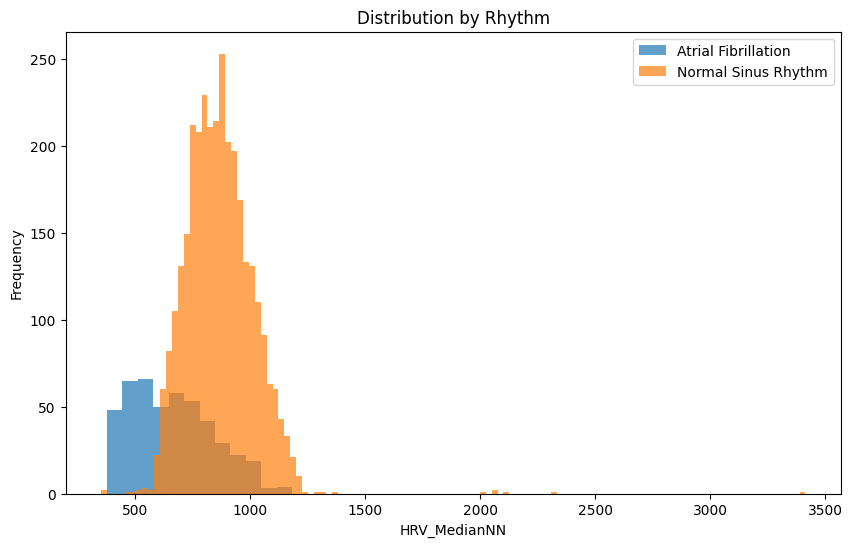

In [81]:
# Merge the HRV data with the rhythm labels
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on='ecg_index', right_index=True
).reset_index(drop=True)

plt.figure(figsize=(10, 6))

selectedMetric = 'HRV_MedianNN'
rhythms = hrv_train_with_labels['label'].unique()
for rhythm in rhythms:
    subset = hrv_train_with_labels[hrv_train_with_labels['label'] == rhythm]
    plt.hist(subset[selectedMetric], alpha=0.7, label=rhythm, bins='auto')

plt.xlabel(selectedMetric)
plt.ylabel('Frequency')
plt.title('Distribution by Rhythm')
plt.legend()
plt.show()

# **Visualisations**

## Correlation plot

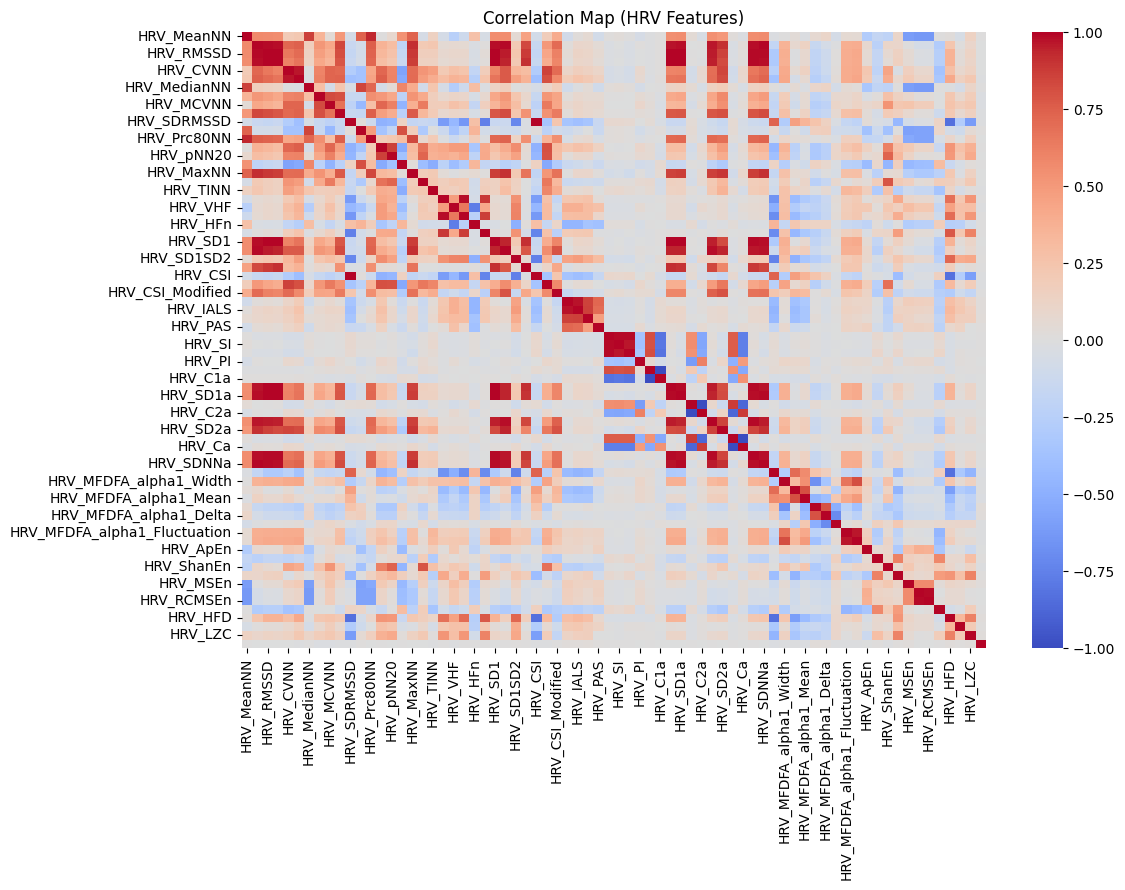

Top 10 HRV features correlated with AF:
af            1.000000
HRV_pNN50     0.623008
HRV_MCVNN     0.557303
HRV_pNN20     0.498333
HRV_CVSD      0.490149
HRV_HTI       0.480988
HRV_ShanEn    0.445086
HRV_CVNN      0.439406
HRV_VHF       0.437533
HRV_CVI       0.418065
Name: af, dtype: float64

Bottom 10 (most negative):
HRV_MFDFA_alpha1_Peak   -0.227188
HRV_MFDFA_alpha1_Max    -0.234791
HRV_CSI                 -0.298195
HRV_DFA_alpha1          -0.299883
HRV_SDRMSSD             -0.301328
HRV_MeanNN              -0.325148
HRV_HFn                 -0.333942
HRV_MedianNN            -0.407720
HRV_MinNN               -0.506329
HRV_Prc20NN             -0.538245
Name: af, dtype: float64


In [98]:
# Correlation heatmap
corr_plot_hrv(hrv_train_clean)

# Quick ranking: strongest HRV–AF correlations (top 10)
hrv_only = hrv_train_with_labels[feature_cols + ["af"]]
corr_with_af = hrv_only.corr()["af"].sort_values(ascending=False)

print("Top 10 HRV features correlated with AF:")
print(corr_with_af.head(10))

print("\nBottom 10 (most negative):")
print(corr_with_af.tail(10))

## Distribution plots

In [41]:
distplots(hrv_train_clean)

NameError: name 'hrv_train_clean' is not defined

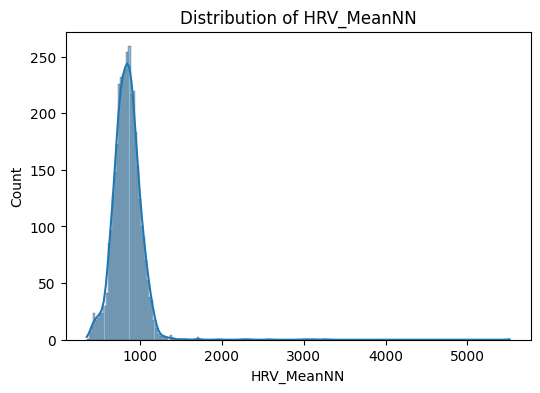

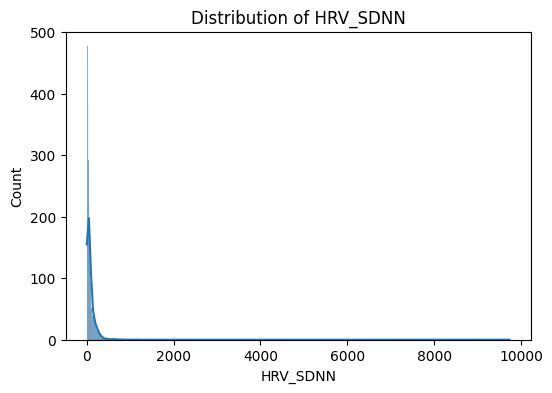

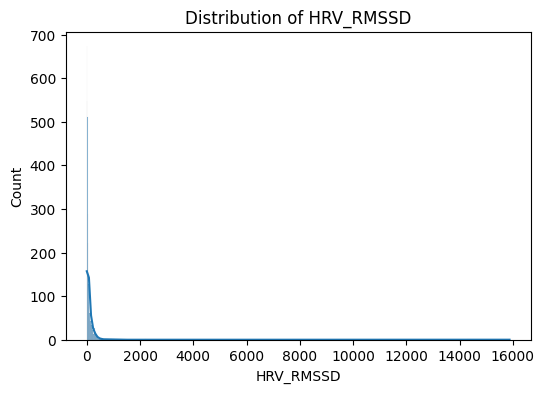

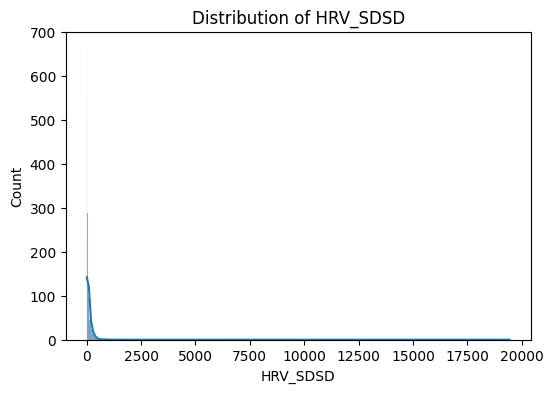

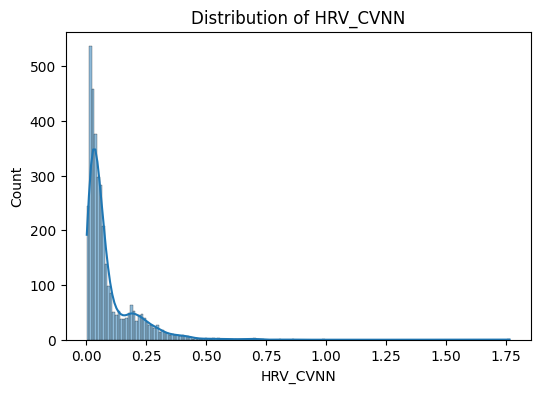

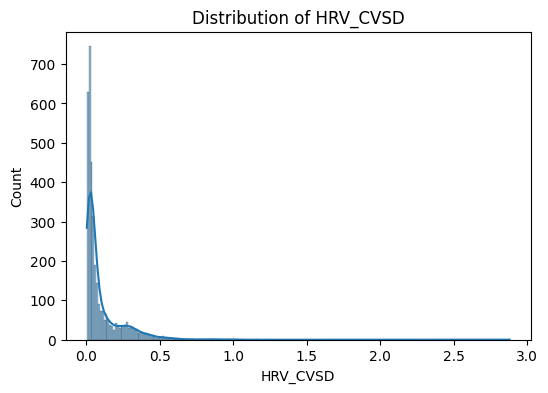

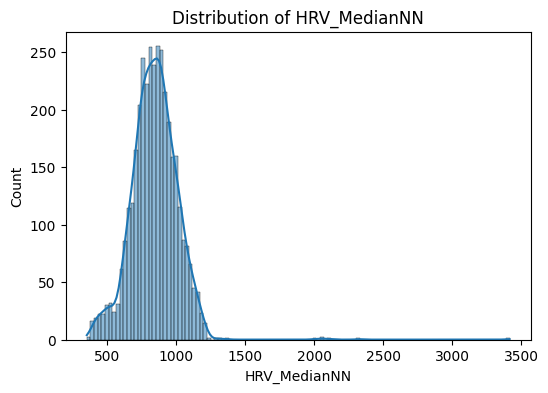

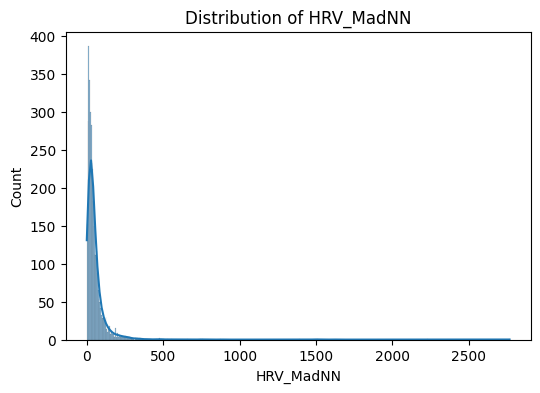

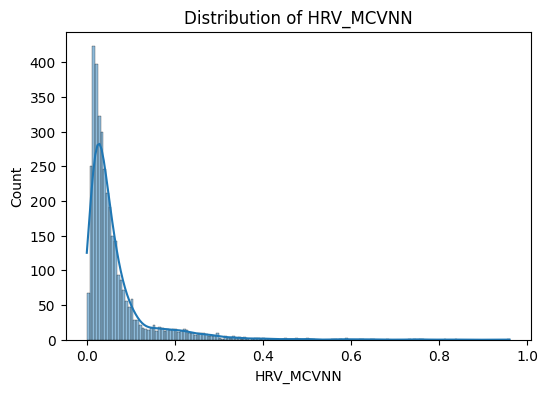

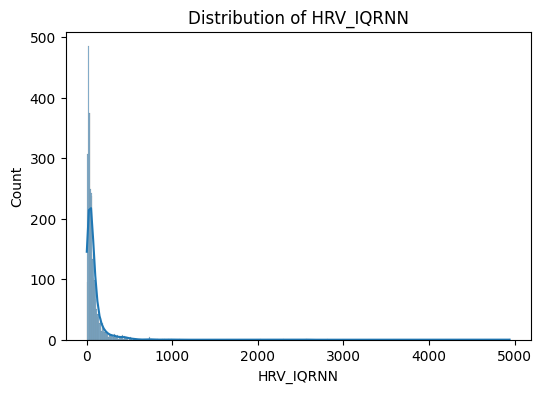

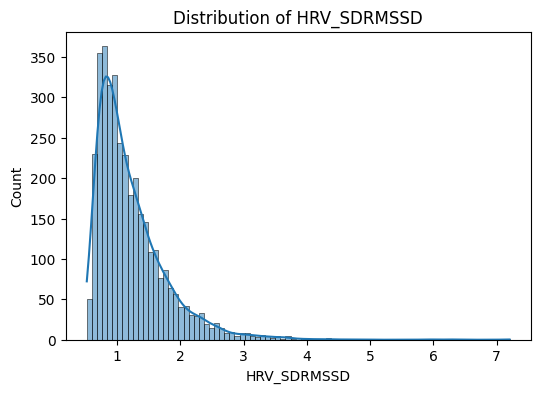

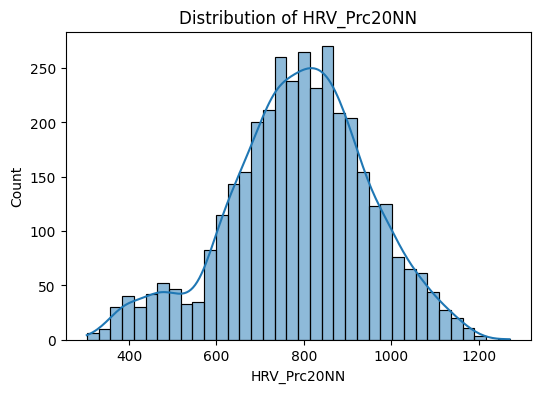

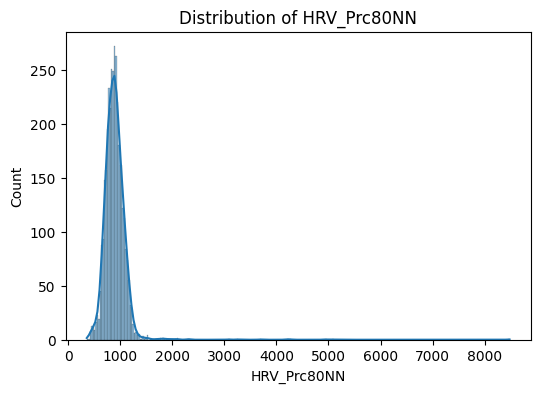

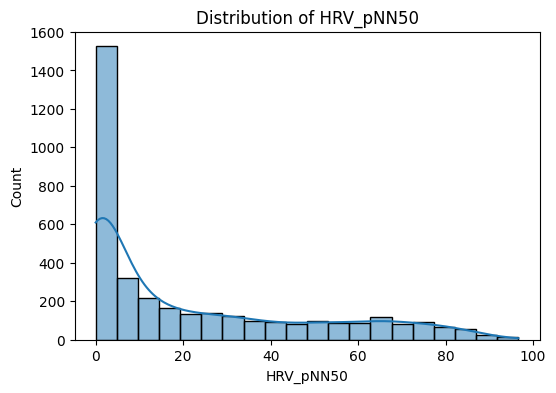

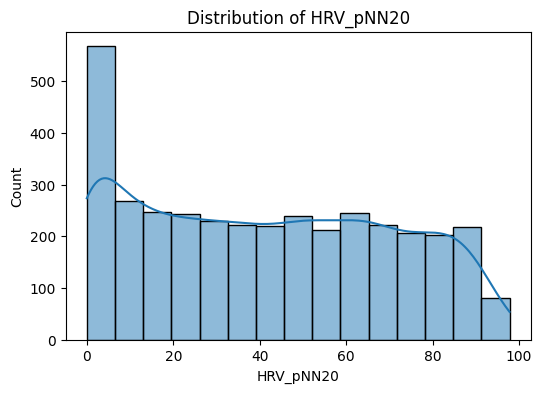

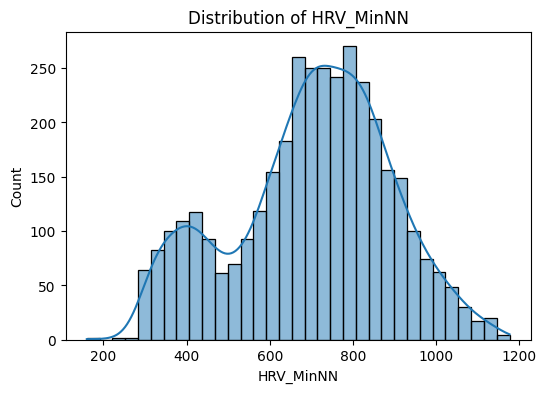

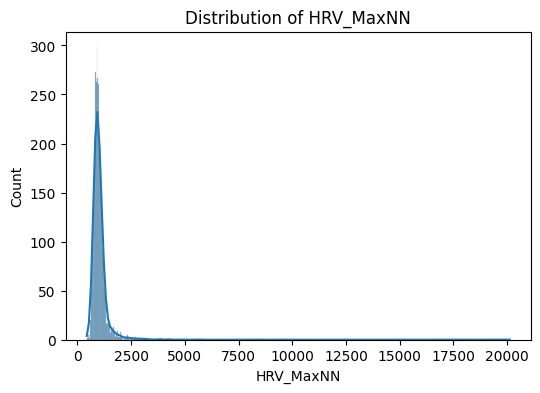

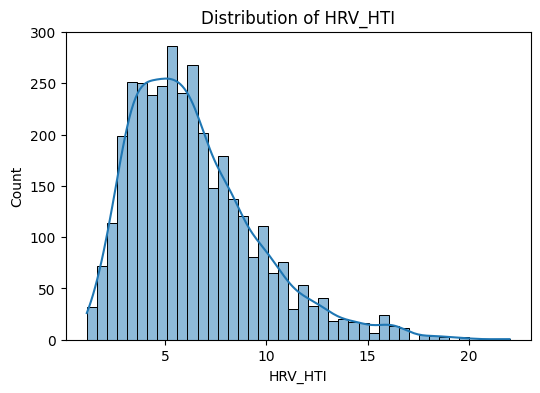

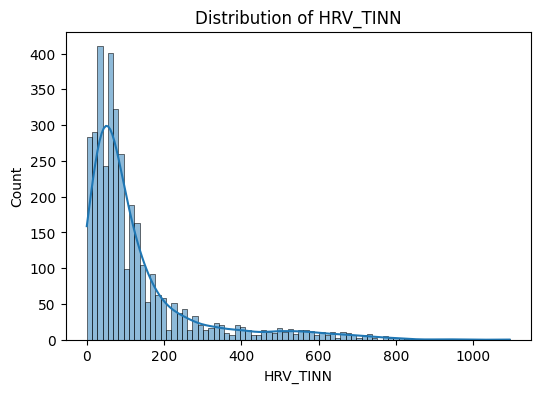

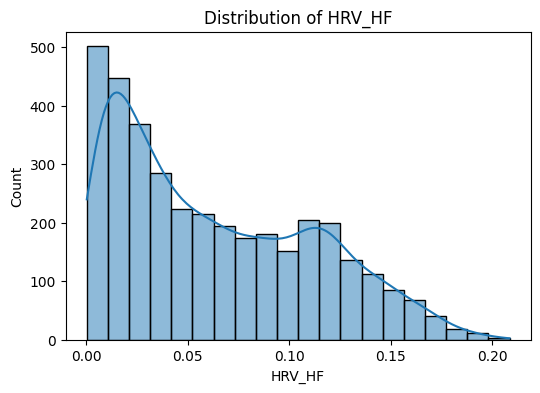

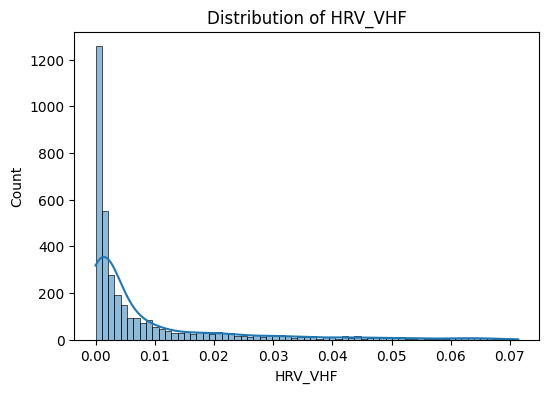

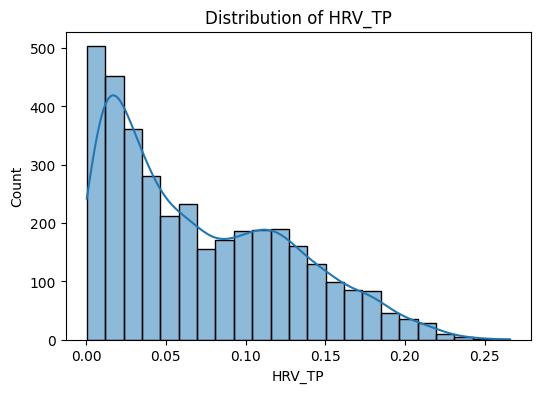

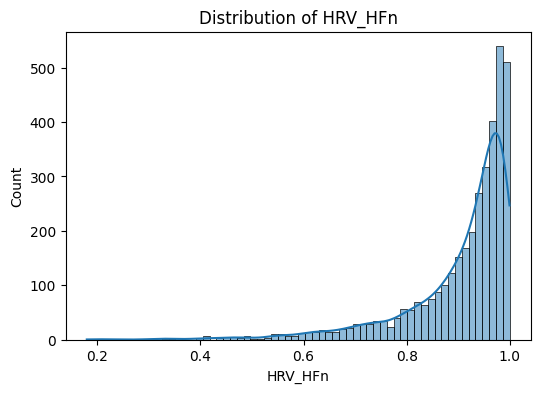

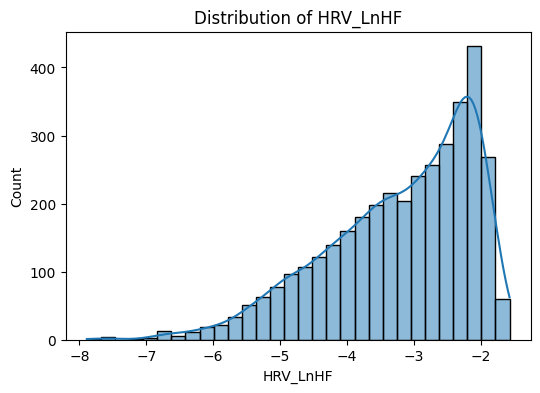

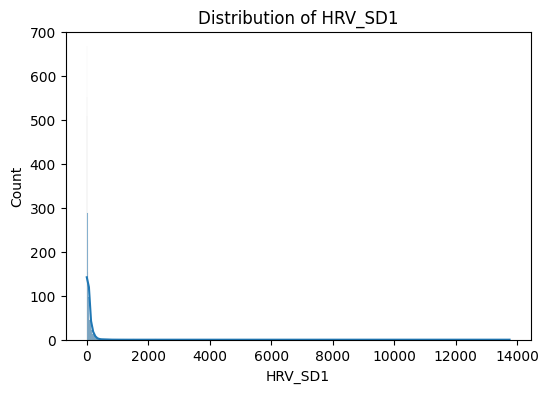

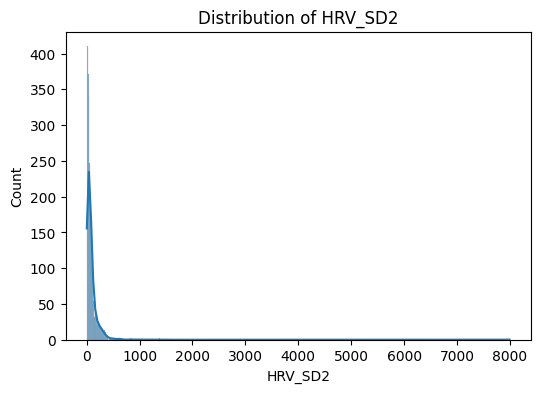

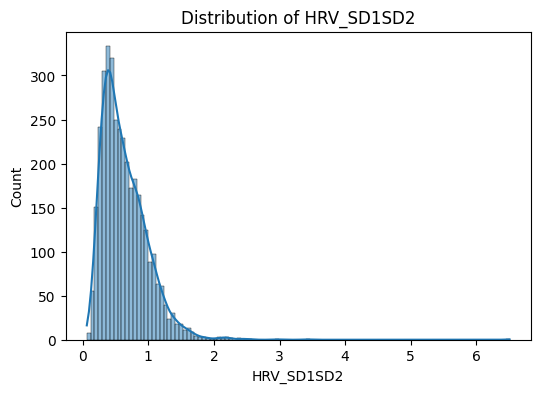

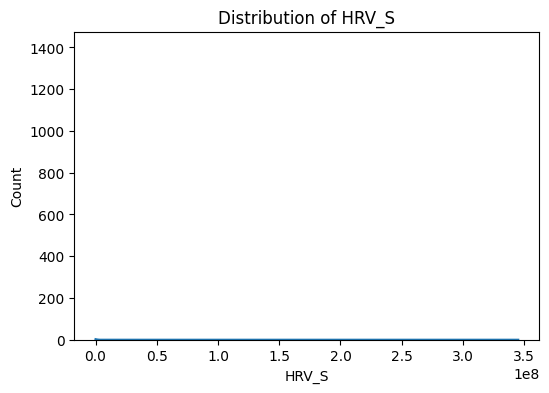

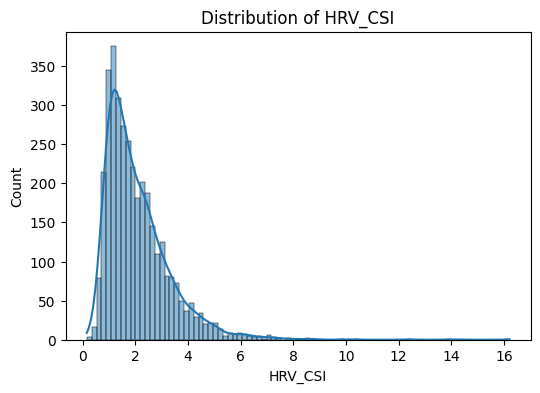

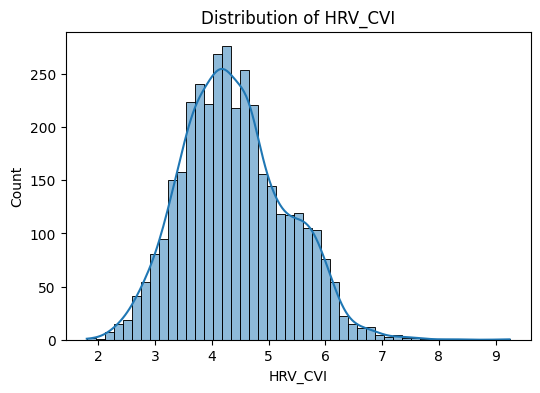

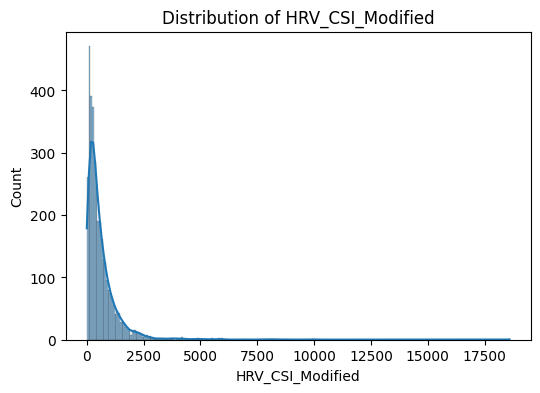

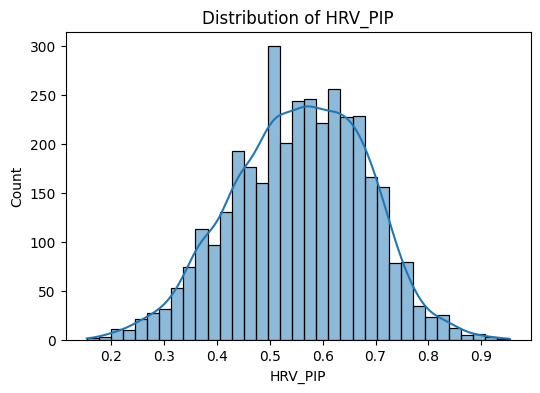

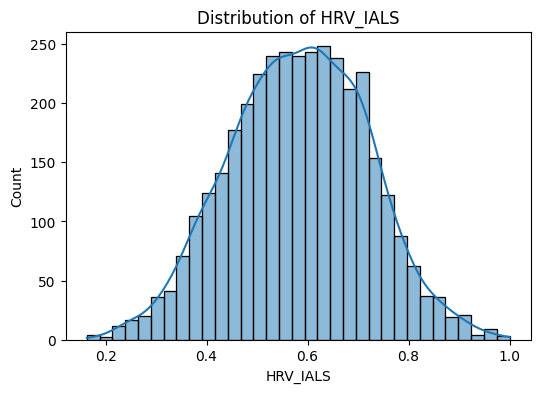

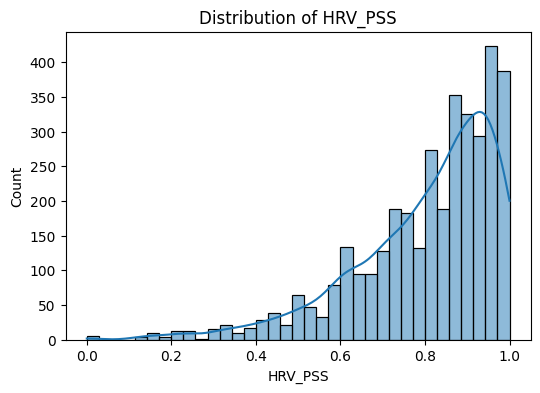

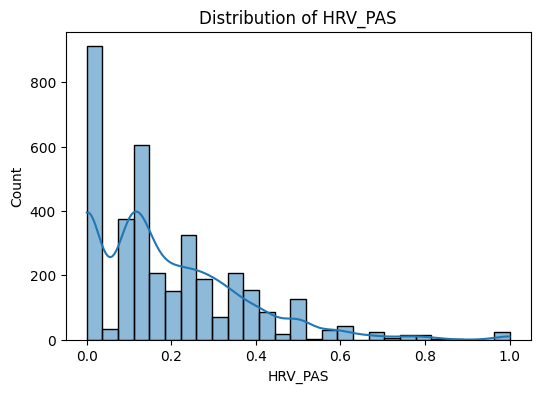

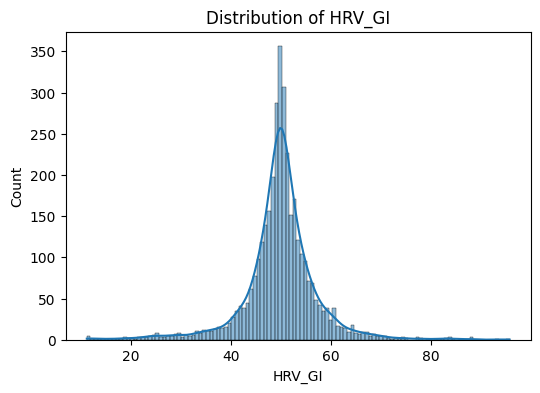

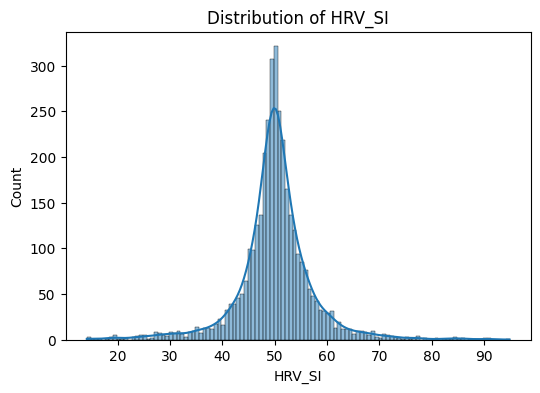

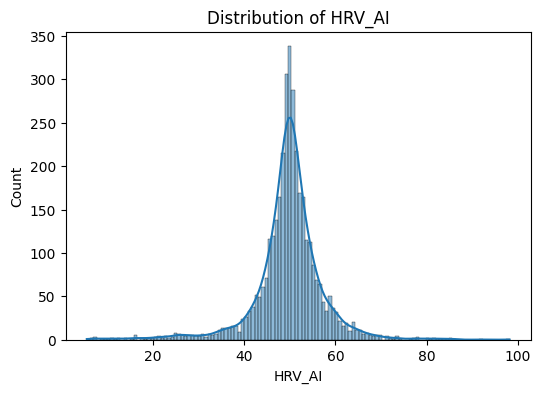

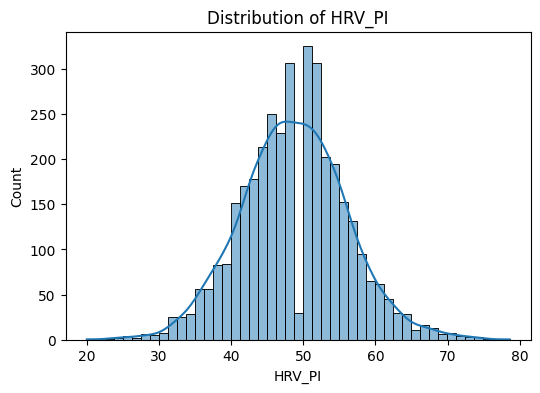

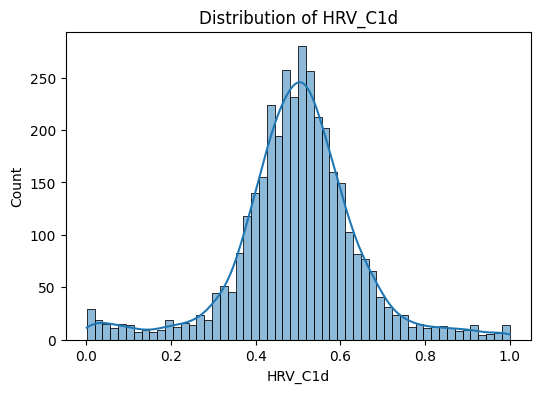

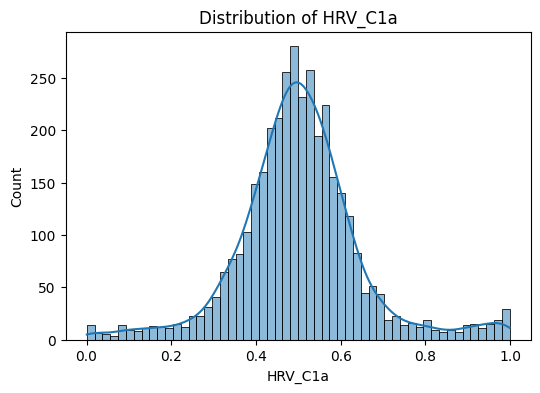

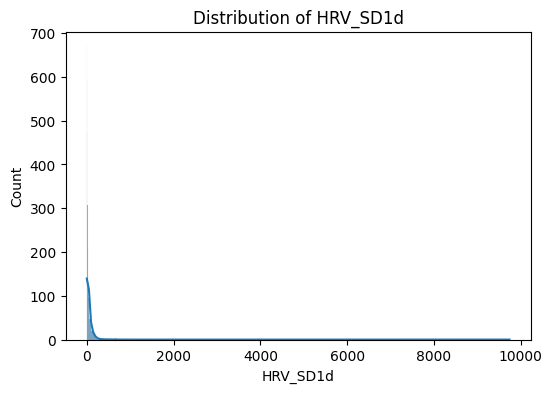

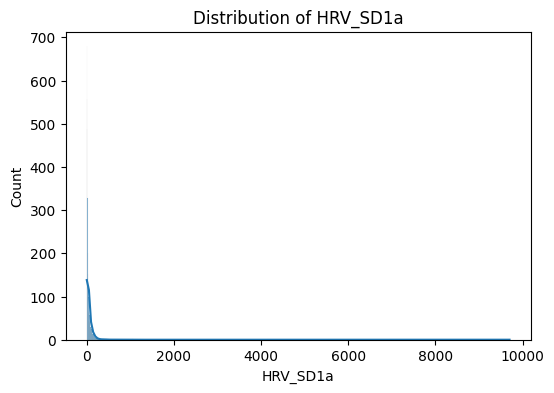

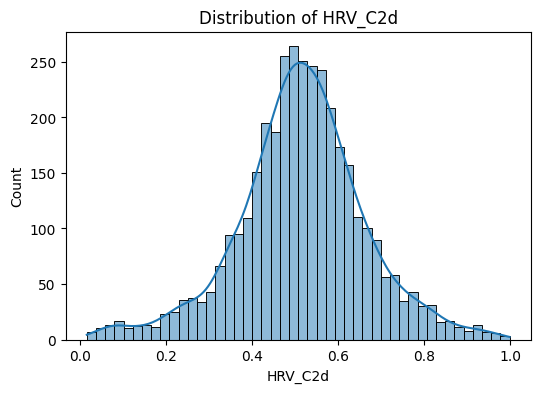

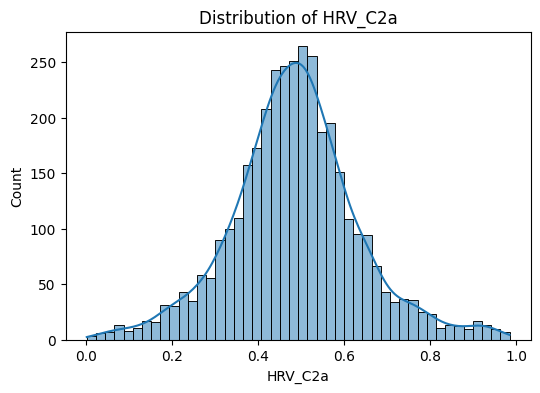

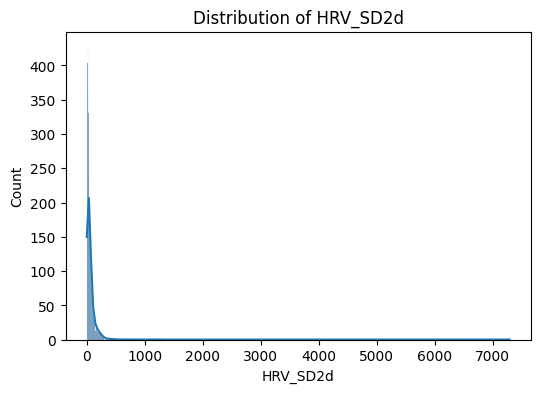

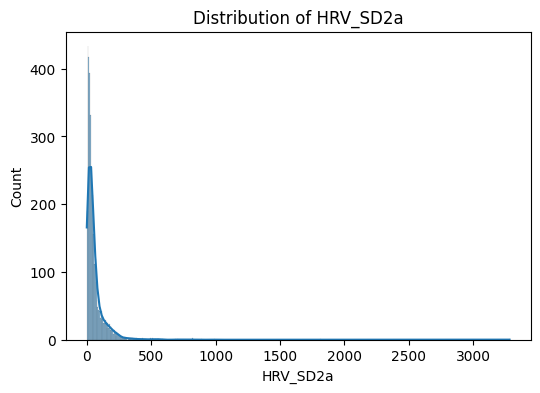

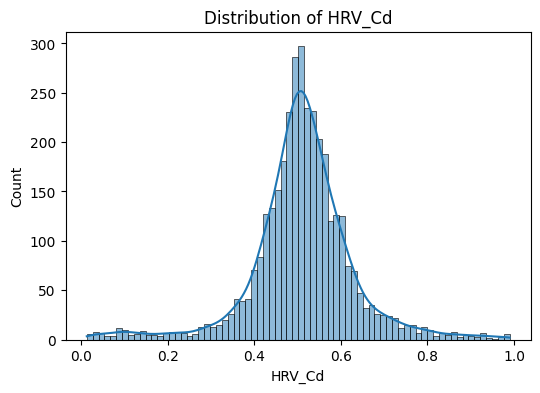

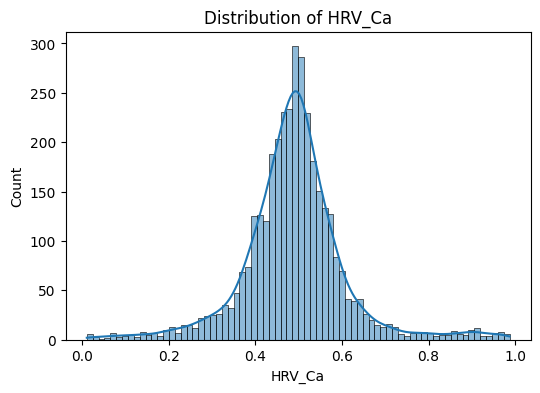

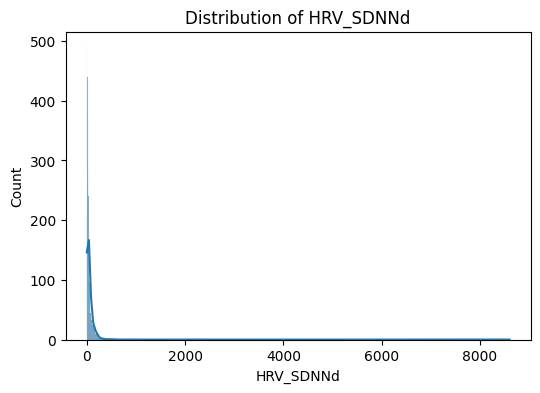

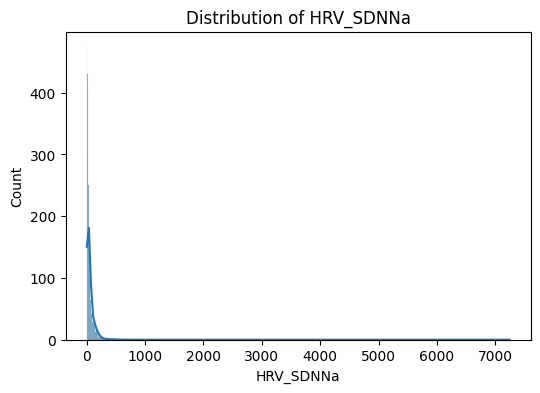

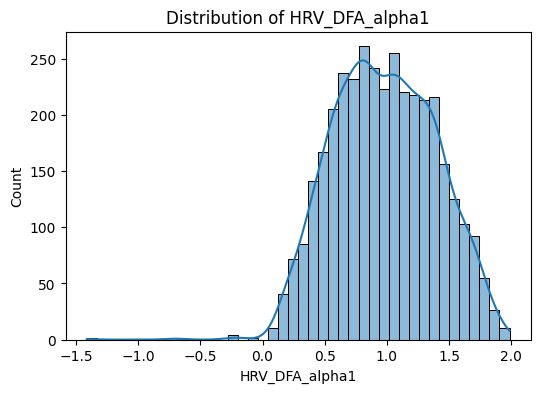

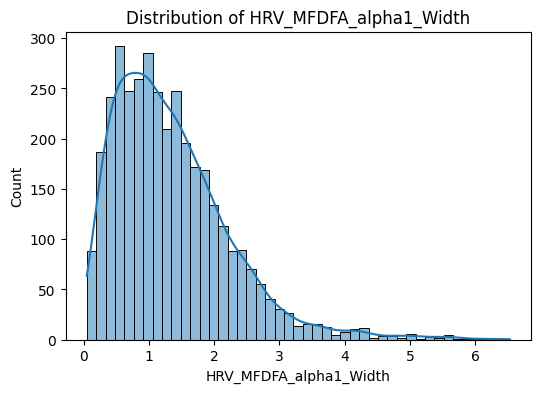

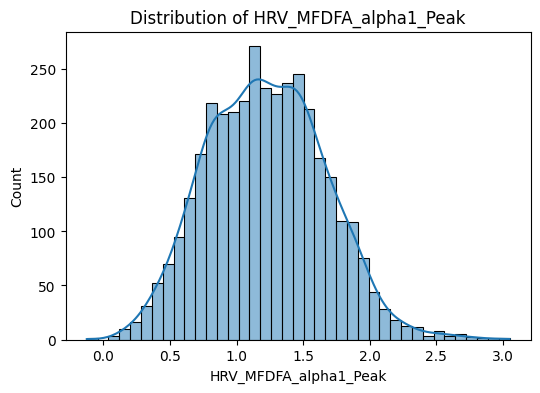

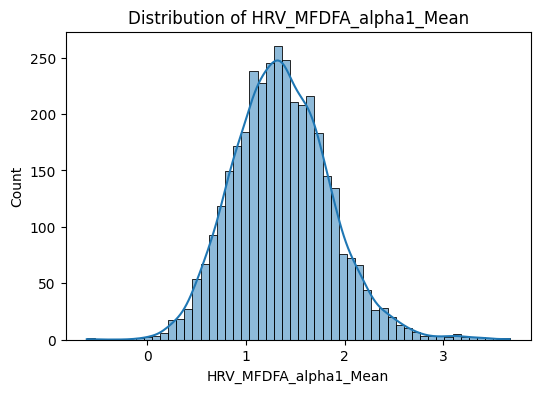

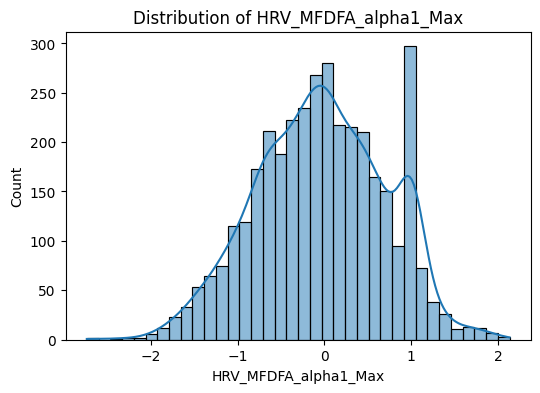

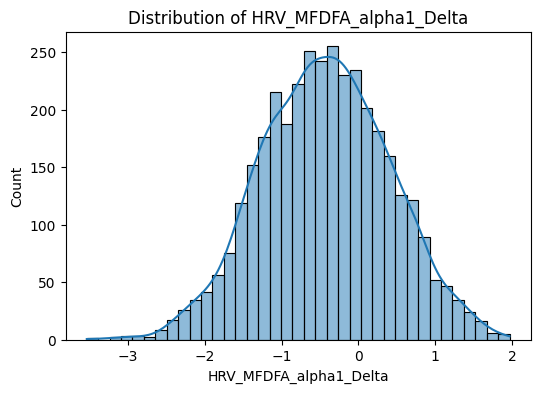

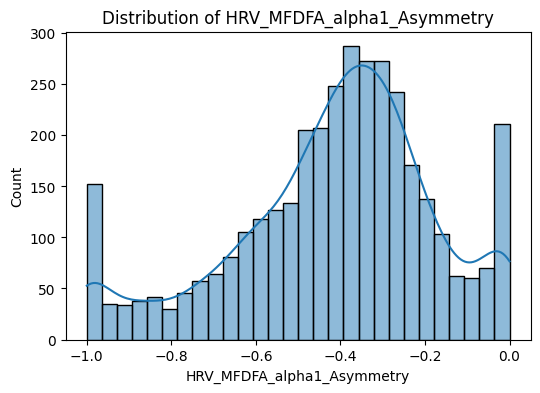

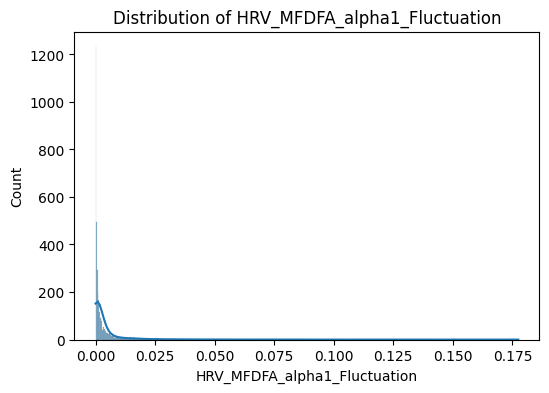

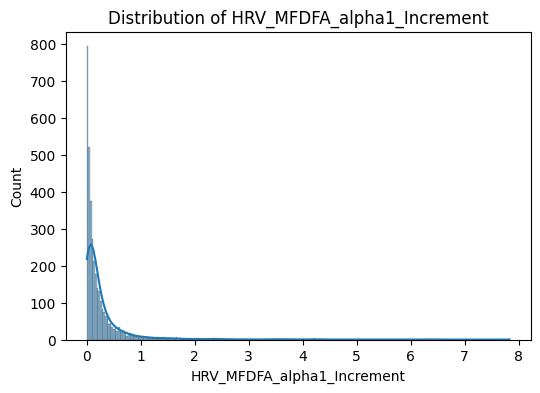

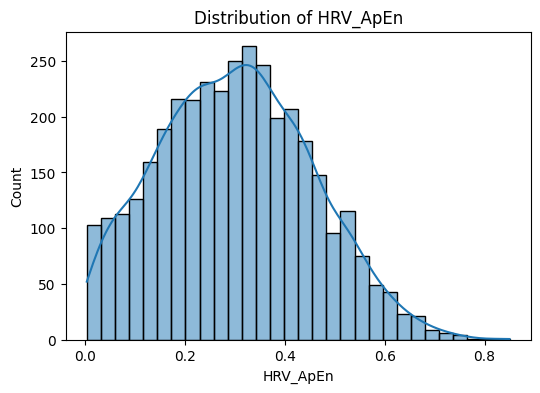

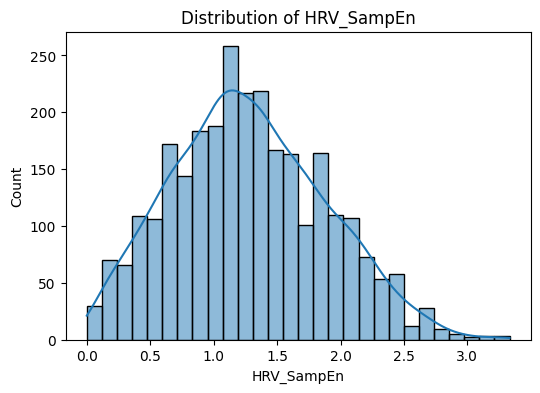

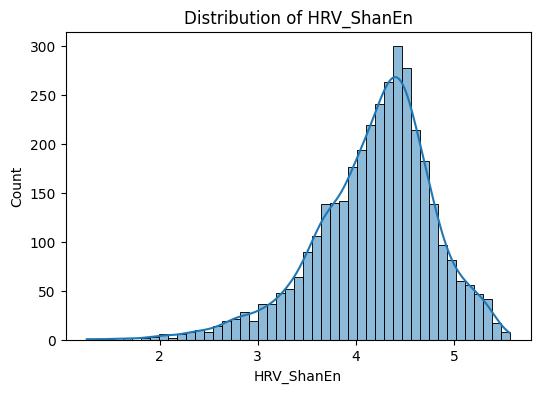

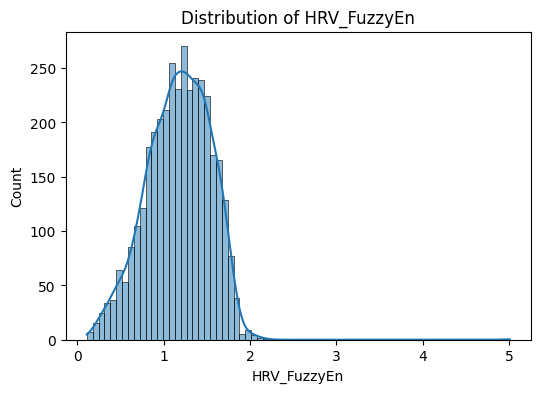

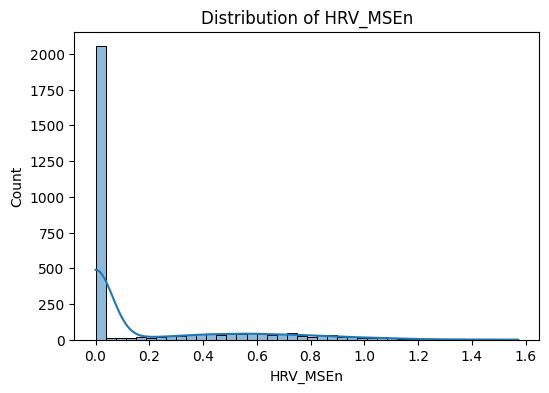

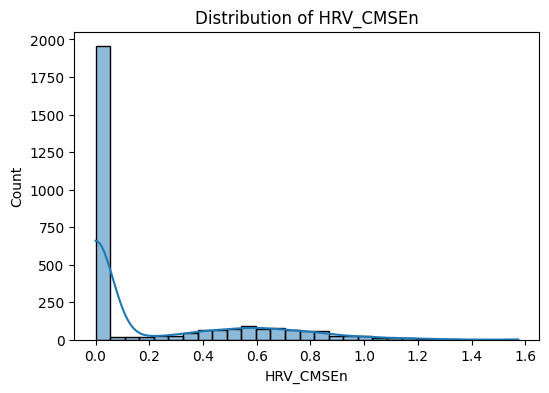

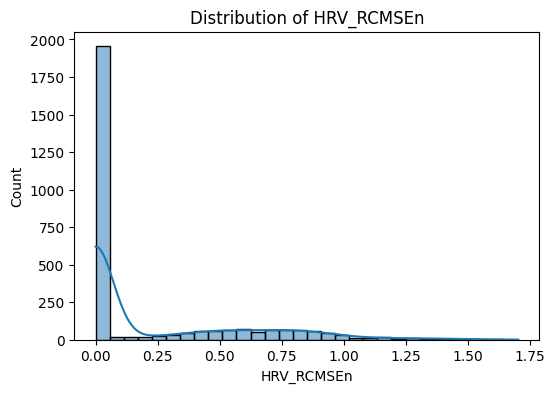

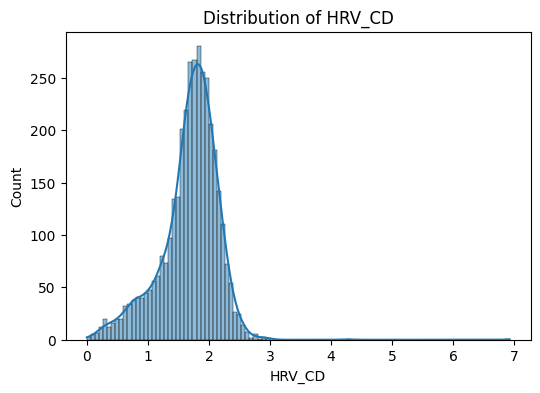

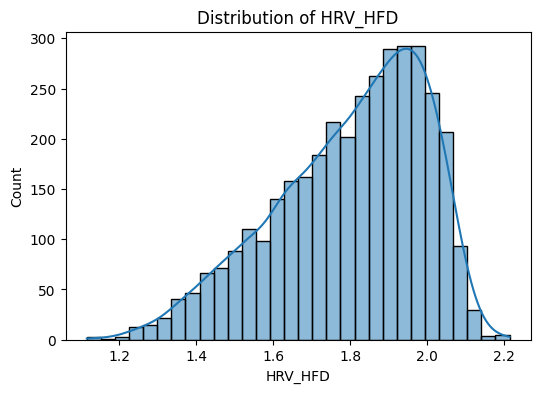

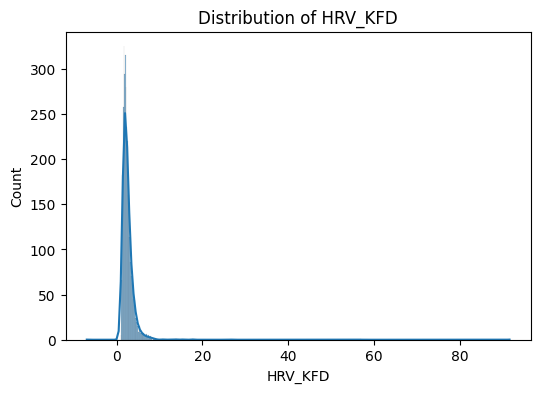

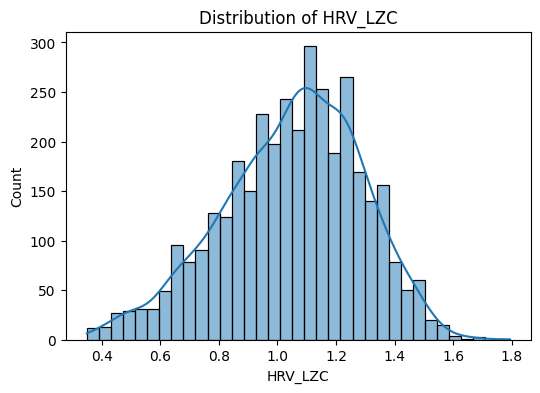

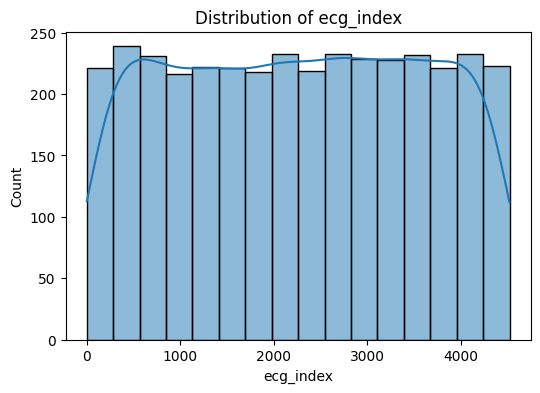

In [83]:
distplots_hrv(hrv_train_clean)

##**Boxplots**

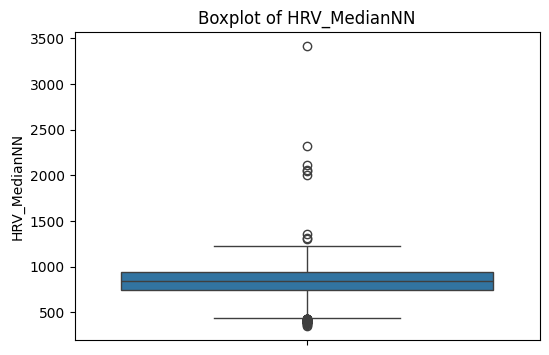

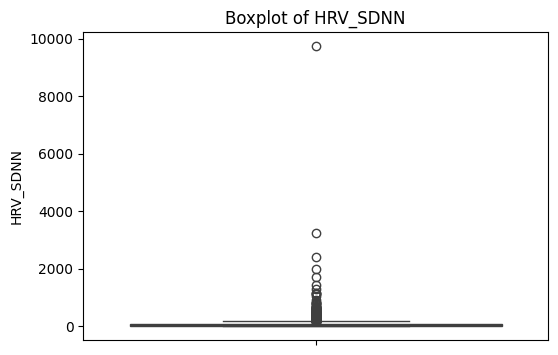

In [84]:
# Boxplots
boxplots_hrv(hrv_train_clean, ["HRV_MedianNN", "HRV_SDNN"])

##**Missingness**

In [85]:
# Missingness
check_missing_hrv(hrv_train_clean)

feature  missing_n  missing_%
HRV_CMSEn            HRV_CMSEn        776  21.442387
HRV_RCMSEn          HRV_RCMSEn        776  21.442387
HRV_MSEn              HRV_MSEn        761  21.027908
HRV_HFD                HRV_HFD         14   0.386847
HRV_DFA_alpha1  HRV_DFA_alpha1          6   0.165792
...                        ...        ...        ...
HRV_ApEn              HRV_ApEn          0   0.000000
HRV_FuzzyEn        HRV_FuzzyEn          0   0.000000
HRV_KFD                HRV_KFD          0   0.000000
HRV_LZC                HRV_LZC          0   0.000000
ecg_index            ecg_index          0   0.000000

[72 rows x 3 columns]

feature  missing_n  missing_%
HRV_MeanNN  HRV_MeanNN          0   0.000000
HRV_SDNN      HRV_SDNN          0   0.000000
HRV_RMSSD    HRV_RMSSD          0   0.000000
HRV_SDSD      HRV_SDSD          0   0.000000
HRV_CVNN      HRV_CVNN          0   0.000000
...                ...        ...        ...
HRV_CD          HRV_CD          1   0.027632
HRV_HFD        HRV_HFD         14   0.386847
HRV_KFD        HRV_KFD          0   0.000000
HRV_LZC        HRV_LZC          0   0.000000
ecg_index    ecg_index          0   0.000000

[72 rows x 3 columns]

### **Outlier Detection**

In [86]:
# Function to identify outliers in the data
def identify_outliers(df, column_name, threshold=1.5):

    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers
    row_indices = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index.tolist()
    outlier_values = df.loc[row_indices, column_name].tolist()

    return row_indices, outlier_values, lower_bound, upper_bound

In [87]:
# Outlier detection ONLY ON TRAIN

# Merge labels with TRAIN features (cleaned hrv_train)
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on="ecg_index", right_index=True
)

# Outlier detection ONLY on TRAIN
train_outlier_idx, outlier_values, iqr_lower, iqr_upper = identify_outliers(
    hrv_train_with_labels,
    "HRV_MedianNN",
    threshold=1.5
)

# ecg_index as (int)
hrv_train_with_labels["ecg_index"] = hrv_train_with_labels["ecg_index"].astype(int)

print("Train outliers detected:", len(train_outlier_idx))
print("Row indices (in hrv_train_with_labels) with outliers:", train_outlier_idx)
print("Outlier HRV_MedianNN values:", outlier_values)

Train outliers detected: 52
Row indices (in hrv_train_with_labels) with outliers: [31, 79, 195, 205, 236, 313, 520, 649, 809, 836, 905, 972, 983, 994, 1002, 1070, 1103, 1121, 1155, 1275, 1280, 1447, 1452, 1562, 1803, 1920, 1996, 2038, 2230, 2329, 2418, 2590, 2623, 2661, 2731, 2779, 2812, 2832, 2864, 2919, 2941, 2987, 3044, 3075, 3238, 3245, 3264, 3292, 3394, 3527, 3586, 3618]
Outlier HRV_MedianNN values: [386.6666666666667, 376.66666666666663, 396.6666666666667, 393.3333333333333, 390.0, 425.0, 425.0, 426.6666666666667, 416.6666666666667, 396.6666666666667, 2063.3333333333335, 430.0, 433.33333333333337, 430.0, 428.33333333333337, 403.3333333333333, 350.0, 3413.333333333333, 405.0, 393.3333333333333, 430.0, 403.33333333333337, 360.0, 1300.0, 2323.333333333333, 1310.0, 1355.0, 396.6666666666667, 396.6666666666667, 390.0, 426.6666666666667, 2116.6666666666665, 413.3333333333333, 413.3333333333333, 398.33333333333337, 380.0, 426.6666666666667, 2050.0, 393.3333333333333, 420.0, 410.0, 398.3

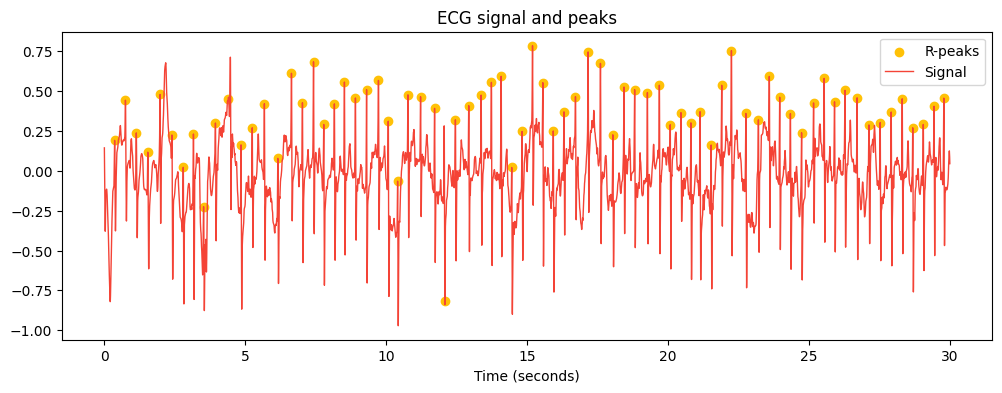

In [88]:
# Visualise one outlier ECG

example_outlier_row = train_outlier_idx[0]

# Single row
row = hrv_train_with_labels.loc[example_outlier_row]

# Extract ECG index value
ecg_index_values = row.filter(like="ecg_index").values

# Use first value
ecg_idx = int(ecg_index_values[0])

# Extract raw ECG from df
ecg_raw = df.iloc[ecg_idx].astype(float).values

# Visualise R-Peaks
peaks_outlier, info_outlier = nk.ecg_peaks(
    ecg_raw,
    sampling_rate=sampling_frequency,
    correct_artifacts=True,
    show=True
)

In [89]:
hrv_train_with_labels.loc[example_outlier_row]

HRV_MeanNN             397.522523
HRV_SDNN                40.042066
HRV_RMSSD               45.260955
HRV_SDSD                45.571377
HRV_CVNN                 0.100729
                     ...         
HRV_KFD                  3.061305
HRV_LZC                   1.09085
ecg_index                      27
label         Atrial Fibrillation
af                              1
Name: 31, Length: 74, dtype: object

####**Outliers TEST set** done the same way as for TRAINING

In [90]:
# Align TEST columns to TRAIN columns

# Align TEST columns to TRAIN columns (no leakage, same feature space)
train_cols = hrv_train_clean.columns  # already cleaned on TRAIN
shared_cols = [c for c in train_cols if c in hrv_test.columns]

hrv_test_aligned = hrv_test[shared_cols].copy()

# Merge TEST HRV with labels
hrv_test_with_labels = pd.merge(
    hrv_test_aligned,
    df_labels[["label", "af"]],
    left_on="ecg_index",
    right_index=True
)

In [91]:
# Same IQR bounds as on hrv_train

Q1  = hrv_train_clean["HRV_MedianNN"].quantile(0.25)
Q3  = hrv_train_clean["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hrv_test_clean = hrv_test_with_labels[
    (hrv_test_with_labels["HRV_MedianNN"] >= lower_bound) &
    (hrv_test_with_labels["HRV_MedianNN"] <= upper_bound)
].copy()

print("hrv_test shape:", hrv_test.shape)
print("hrv_test_with_labels shape:", hrv_test_with_labels.shape)
print("hrv_test_clean shape:", hrv_test_clean.shape)

hrv_test shape: (905, 84)
hrv_test_with_labels shape: (905, 74)
hrv_test_clean shape: (883, 74)


##**Distribution TRAIN + TEST | Sanity check**

In [92]:
print(hrv_train_clean.columns[:5])
print(hrv_test_clean.columns[:5])
print(hrv_test_clean[["HRV_MedianNN", "af"]].head())

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'], dtype='object')
Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'], dtype='object')
   HRV_MedianNN  af
0   1120.000000   0
1    583.333333   0
2    635.000000   0
3    718.333333   0
4    916.666667   0


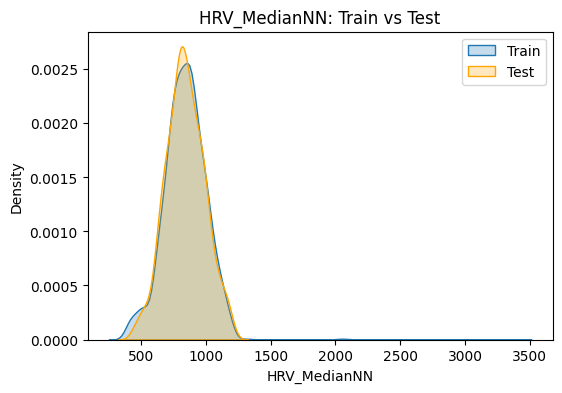

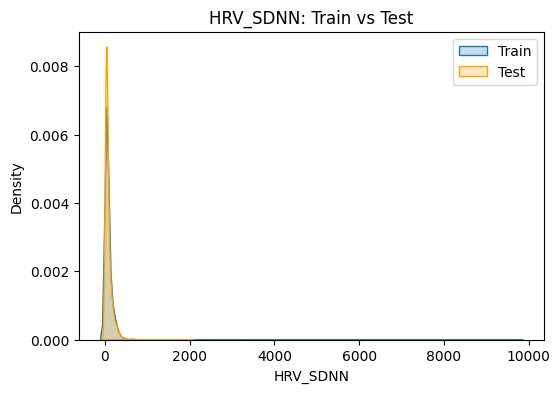

In [93]:
for feat in ["HRV_MedianNN", "HRV_SDNN"]:
    plt.figure(figsize=(6,4))
    sns.kdeplot(
        data=hrv_train_clean, x=feat, label="Train", fill=True, common_norm=False
    )
    sns.kdeplot(
        data=hrv_test_clean, x=feat, label="Test", fill=True, common_norm=False, color="orange"
    )
    plt.title(f"{feat}: Train vs Test")
    plt.legend()
    plt.show()

###**Outlier Handling TRAIN**

####**Winsorising outliers**

In [94]:
Q1 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_clip = Q1 - 1.5 * IQR
upper_clip = Q3 + 1.5 * IQR

hrv_train_winsor = hrv_train_with_labels.copy()
hrv_train_winsor["HRV_MedianNN_winsor"] = hrv_train_with_labels["HRV_MedianNN"].clip(
    lower=lower_clip, upper=upper_clip
)

print("Shape after winsorizing (same as original):", hrv_train_winsor.shape)

Shape after winsorizing (same as original): (3619, 75)


###**Outlier Handling Comparison**

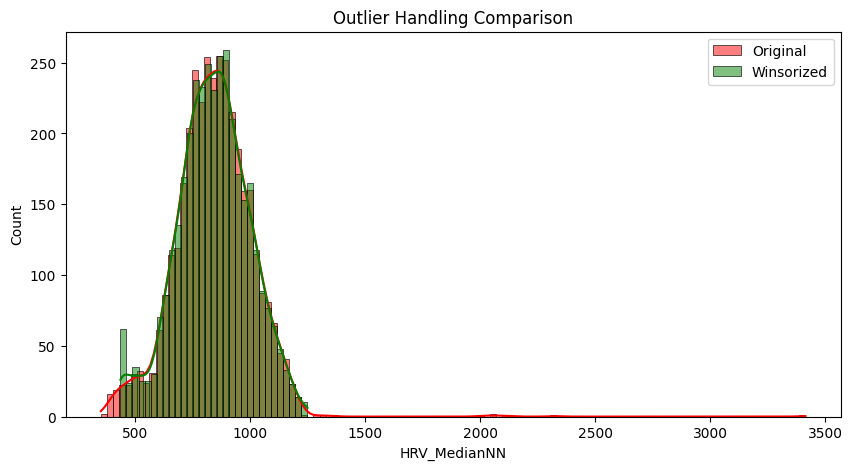

In [95]:
plt.figure(figsize=(10,5))
sns.histplot(hrv_train_with_labels["HRV_MedianNN"], kde=True, color="red", label="Original")
sns.histplot(hrv_train_winsor["HRV_MedianNN_winsor"], kde=True, color="green", label="Winsorized")

plt.legend()
plt.title("Outlier Handling Comparison")
plt.show()

# **Final Preprocessing: Building ML Matrices (X_train, X_test)**

In [96]:
# Select HRV feature columns only
feature_cols = [col for col in hrv_train_with_labels.columns
                if col.startswith("HRV_")]

# TRAIN data
X_train = hrv_train_with_labels[feature_cols].copy()
y_train = hrv_train_with_labels["af"].copy()

# TEST data
X_test  = hrv_test_clean[feature_cols].copy()
y_test  = hrv_test_clean["af"].copy()

In [99]:
# Replace +/- inf with NaN in both TRAIN and TEST
for df_ in (X_train, X_test):
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns that are all-NaN (if any)
all_nan_cols = X_train.columns[X_train.isna().all()]
if len(all_nan_cols) > 0:
    print("Dropping all-NaN columns before imputation:", list(all_nan_cols))
    X_train.drop(columns=all_nan_cols, inplace=True)
    X_test.drop(columns=all_nan_cols, inplace=True)

## **Imputation**

In [100]:
# Median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# X_train: fit_transform
X_train_imputed = imputer.fit_transform(X_train)

# X_test: only transform (so test set remains untouched)
X_test_imputed  = imputer.transform(X_test)

## **Scaling**

In [101]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# X_train: fit_transform
X_train_scaled = scaler.fit_transform(X_train_imputed)

# X_test: only transform (so test set remains untouched)
X_test_scaled  = scaler.transform(X_test_imputed)

# Convert back to df with column names
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test  = pd.DataFrame(X_test_scaled,  columns=feature_cols)

### **Sanity checks**

In [102]:
# Median X_train

print("Median of scaled features (should be ~0):")
print(X_train.median().round(3))

# IQR X_train
print("\nIQR of scaled features (should be ~1):")
print((X_train.quantile(0.75) - X_train.quantile(0.25)).round(3))

Median of scaled features (should be ~0):
HRV_MeanNN    0.0
HRV_SDNN      0.0
HRV_RMSSD     0.0
HRV_SDSD      0.0
HRV_CVNN      0.0
             ... 
HRV_RCMSEn    0.0
HRV_CD        0.0
HRV_HFD       0.0
HRV_KFD       0.0
HRV_LZC       0.0
Length: 71, dtype: float64

IQR of scaled features (should be ~1):
HRV_MeanNN    1.0
HRV_SDNN      1.0
HRV_RMSSD     1.0
HRV_SDSD      1.0
HRV_CVNN      1.0
             ... 
HRV_RCMSEn    0.0
HRV_CD        1.0
HRV_HFD       1.0
HRV_KFD       1.0
HRV_LZC       1.0
Length: 71, dtype: float64


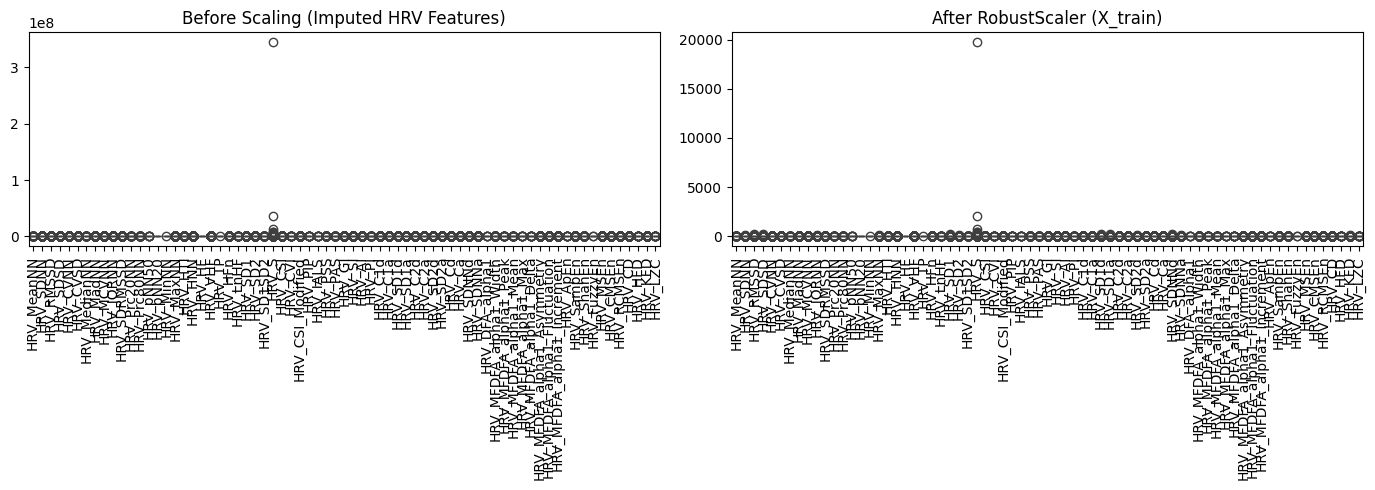

In [103]:
# Boxplot scaled feature distributions

X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=feature_cols)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=X_train_imputed_df, ax=axes[0])
axes[0].set_title("Before Scaling (Imputed HRV Features)")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=X_train, ax=axes[1])
axes[1].set_title("After RobustScaler (X_train)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# **Final ML datasets (X_train, X_test, y_train, y_test)**

In [104]:
# Feature matrices (winsorised > imputation > scaling)
X_train = X_train_scaled
X_test  = X_test_scaled

# Target vectors (created earlier from HRV + labels AF(0/1))
y_train = hrv_train_with_labels["af"].copy()
y_test  = hrv_test_clean["af"].copy()

print("Final X_train shape:", X_train.shape)
print("Final X_test shape:", X_test.shape)
print("Final y_train shape:", y_train.shape)
print("Final y_test shape:", y_test.shape)

Final X_train shape: (3619, 71)
Final X_test shape: (883, 71)
Final y_train shape: (3619,)
Final y_test shape: (883,)


## **Safety check**

In [105]:
assert len(X_train) == len(y_train), "Misaligned TRAIN matrix and labels!"
assert len(X_test)  == len(y_test),  "Misaligned TEST matrix and labels!"

assert not np.isnan(X_train).any(), "NaNs detected in X_train!"
assert not np.isnan(X_test).any(),  "NaNs detected in X_test!"

## Defining the table of results to compare

In [123]:
resultsTable = pd.DataFrame(columns = ['Model', 'Hyperparameters', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC'])

def modelResults(model, hyperparams, accuracy, f1, precision, recall, auc):
    print(f"Model {model} evaluated with hyperparameters {hyperparams}. \nAccuracy: {accuracy} \nF1 Score: {f1} \nPrecision: {precision} \nRecall: {recall} \nAUC: {auc}")
    resultsTable.loc[len(resultsTable)] = [model, hyperparams, accuracy, f1, precision, recall, auc]
    resultsTable.to_csv("trainingResults.csv", index=False)

In [124]:
modelResults("a", "b", "c", "d", "e", "f", "g")
resultsTable

Model a evaluated with hyperparameters b. 
Accuracy: c 
F1 Score: d 
Precision: e 
Recall: f 
AUC: g


Model Hyperparameters Accuracy F1 Score Precision Recall AUC
0     a               b        c        d         e      f   g

# Comparing results